In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.pipeline import Pipeline

In [13]:
train = pd.read_csv("./input/Train/train.csv")
test = pd.read_csv("./input/Test/test.csv")

print("shape of train: ", train.shape, "shape of test: ", test.shape)

shape of train:  (7767, 563) shape of test:  (3162, 563)


In [14]:
print(train.isnull().values.any())
print(test.isnull().values.any())

False
False


Observation: Train data and test data is divided in approximately 70:30. There are no missing values.

### Visualizations for Train data

In [15]:
print(train.Activity.value_counts())

STANDING              1423
LAYING                1413
SITTING               1293
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     987
STAND_TO_LIE            90
SIT_TO_LIE              75
LIE_TO_SIT              60
LIE_TO_STAND            57
STAND_TO_SIT            47
SIT_TO_STAND            23
Name: Activity, dtype: int64


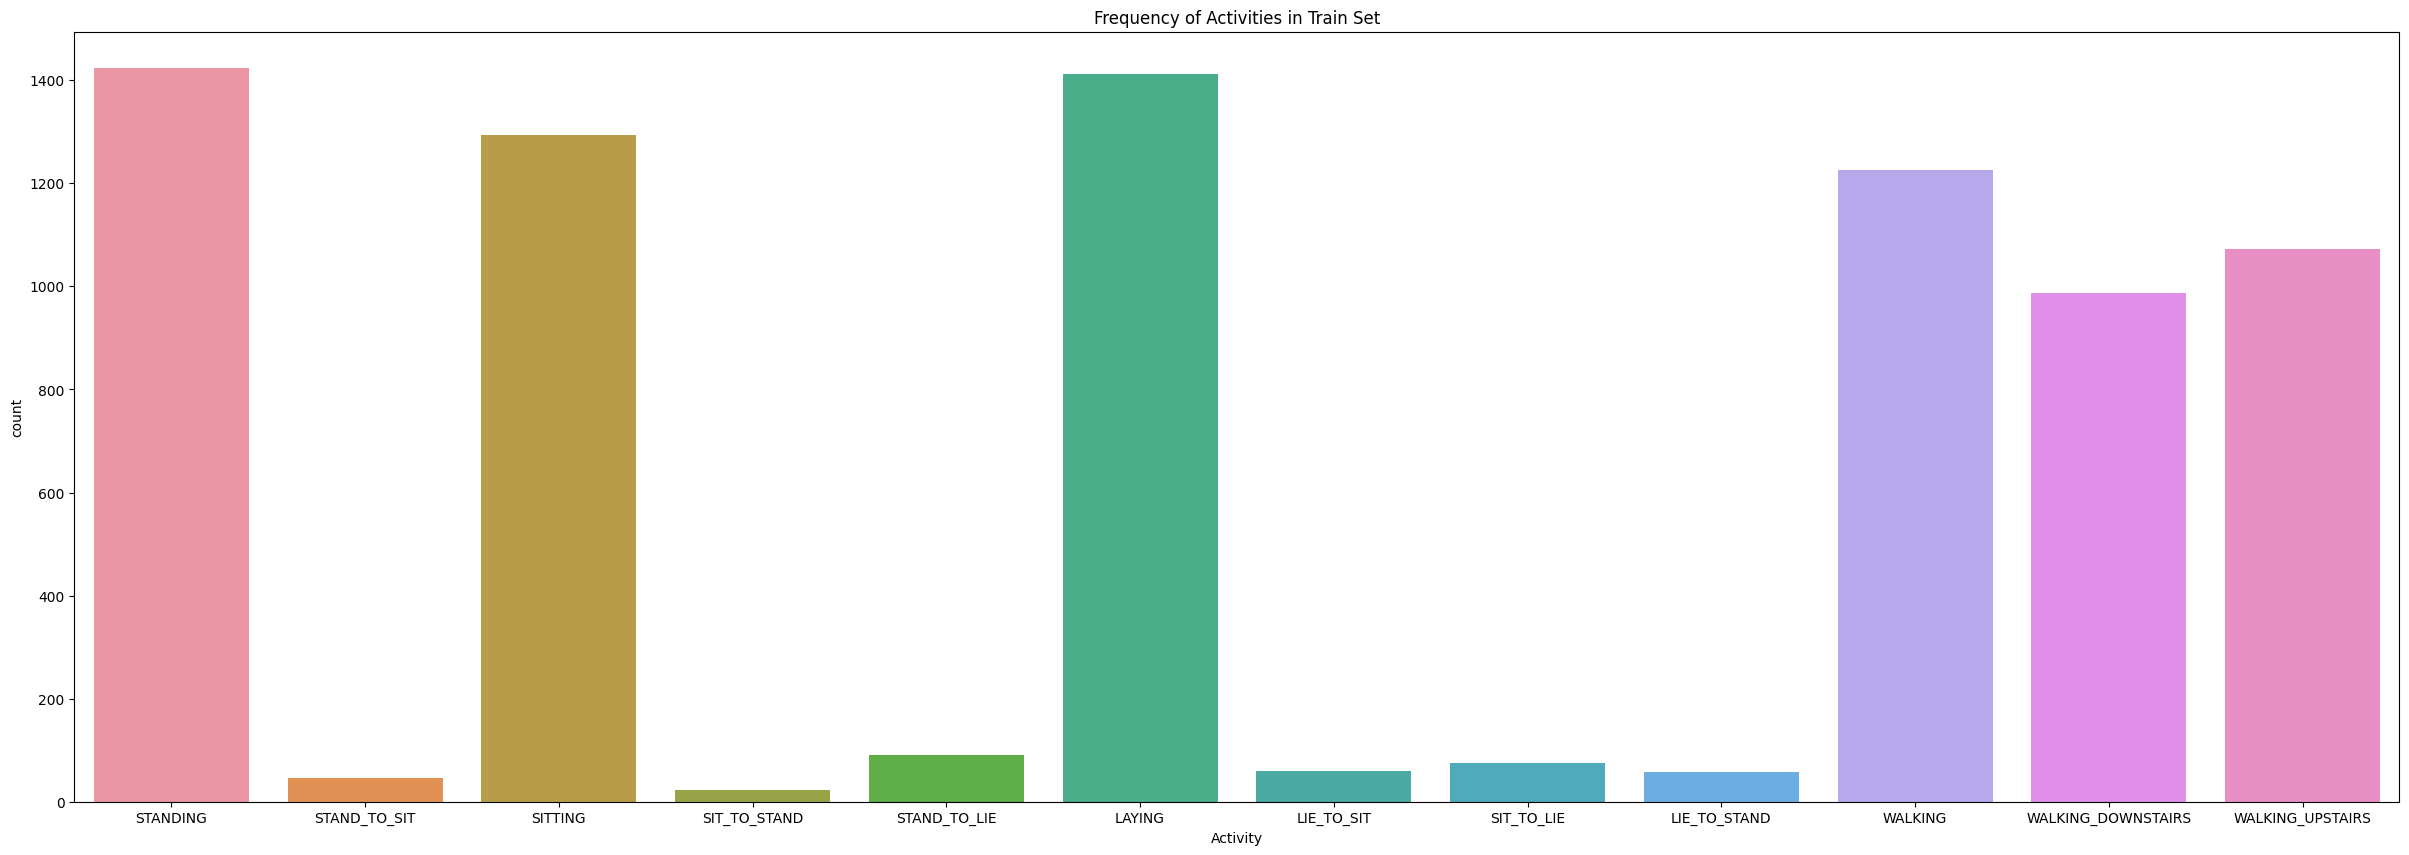

In [16]:
plt.figure(figsize = (30,10))
sns.countplot(x=train.Activity)
plt.xlabel('Activity')
plt.ylabel('count')
plt.title('Frequency of Activities in Train Set')
plt.show()

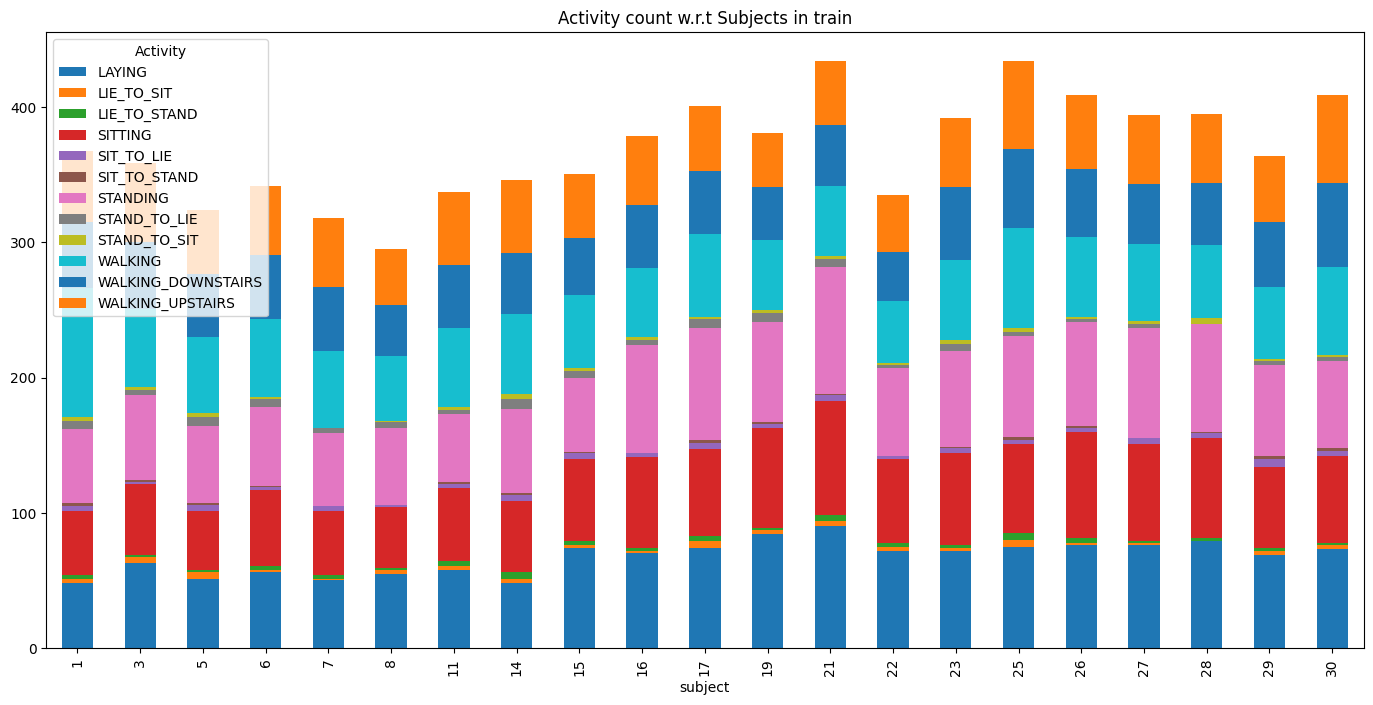

In [17]:
# Stacked Bar Chart for different activities with regards to subjects

stack_group = train.groupby(['subject', 'Activity']).size().unstack()
stack_group.plot(kind='bar', stacked=True, figsize=(17, 8), title = 'Activity count w.r.t Subjects in train')
plt.show()

### Visualizations for Test data

In [18]:
print(test.Activity.value_counts())

STANDING              556
LAYING                545
SITTING               508
WALKING               496
WALKING_UPSTAIRS      471
WALKING_DOWNSTAIRS    420
STAND_TO_LIE           49
SIT_TO_LIE             32
LIE_TO_STAND           27
LIE_TO_SIT             25
STAND_TO_SIT           23
SIT_TO_STAND           10
Name: Activity, dtype: int64


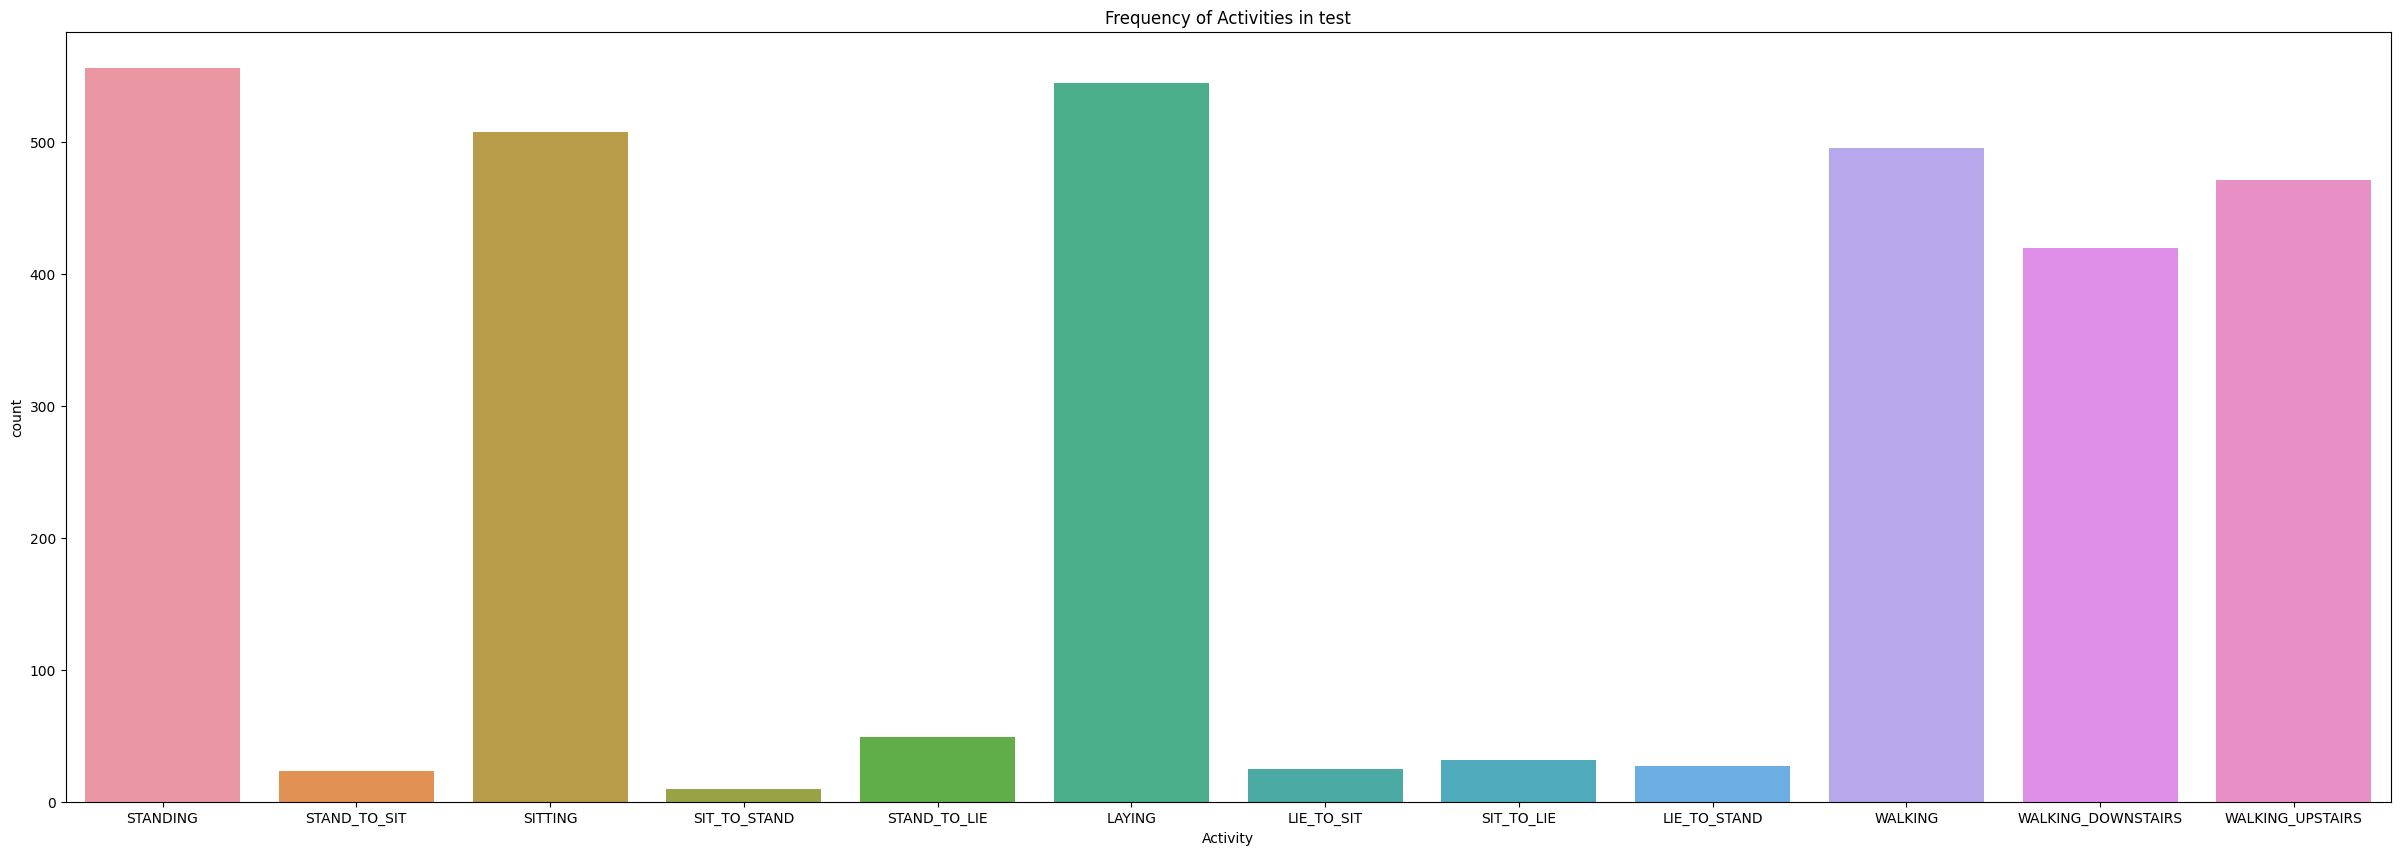

In [19]:
plt.figure(figsize = (30,10))
sns.countplot(x=test.Activity)
plt.xlabel('Activity')
plt.ylabel('count')
plt.title('Frequency of Activities in test')
plt.show()

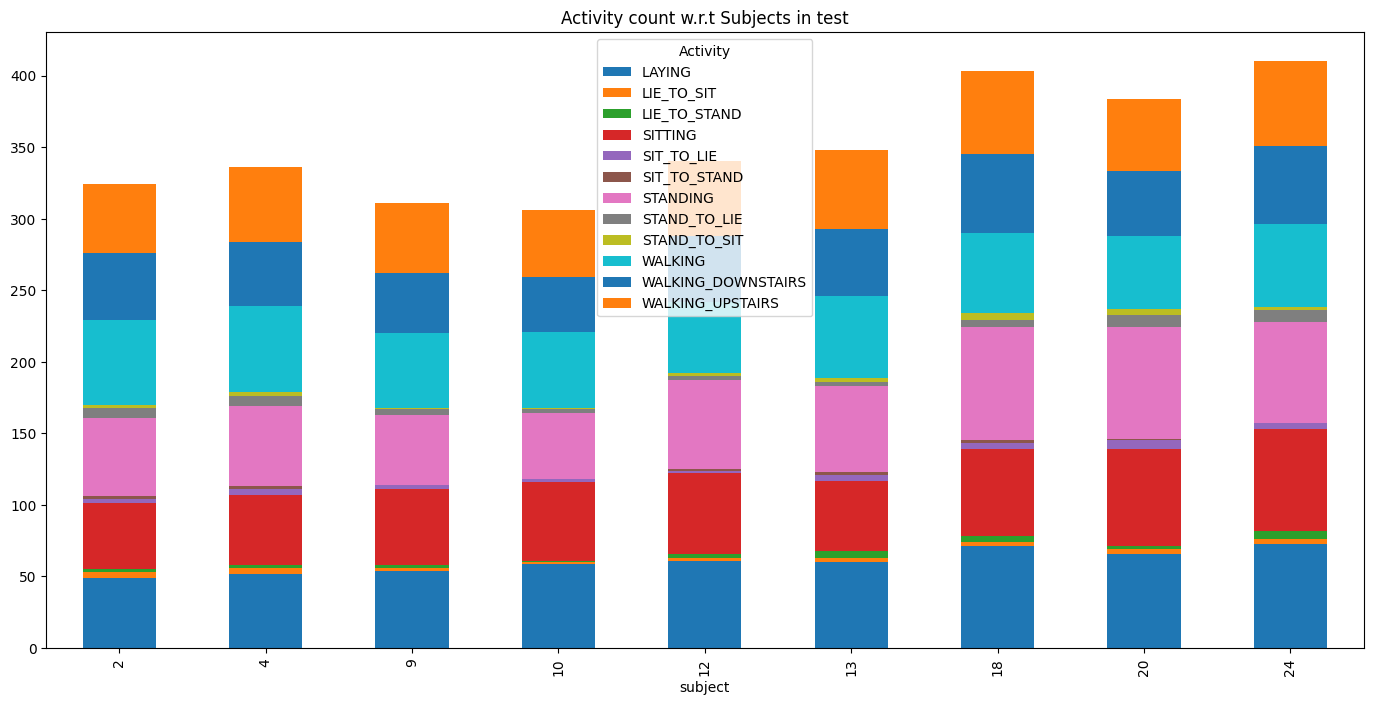

In [20]:
# Stacked Bar Chart for different activities with regards to subjects

stack_group = test.groupby(['subject', 'Activity']).size().unstack()
stack_group.plot(kind='bar', stacked=True, figsize=(17, 8), title = 'Activity count w.r.t Subjects in test')
plt.show()

# Split train dataset into train and validation

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [11]:
# First, we need to standardize the data to get better performance
features = train.columns.values.tolist()
features.remove('Activity')
features.remove('subject')

# Separating out the features
x = train.loc[:, features].values

# Separating out the target
y = train.loc[:,['Activity']].values

train_features, validation_features, train_labels, validation_labels = train_test_split(x, y, test_size=0.25, random_state=1300)

# Standardizing the features
sc = StandardScaler()
train_features = sc.fit_transform(train_features)
validation_features = sc.transform(validation_features)

targets = train['Activity'].unique()

train_labels = pd.DataFrame(train_labels, columns=['Activity'])
validation_labels = pd.DataFrame(validation_labels, columns=['Activity'])

### Principal Component Analysis (PCA)
We want to use PCA to reduce the the multidimension features in our data into fewer dimensions to better understand the data distribution. We are interested to find out whether the classes are separable using these selected principal components.

#### 2 Components PCA

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train = pca.fit_transform(train_features)
principalDf = pd.DataFrame(data = X_train
             , columns = ['PC1', 'PC2'])

In [24]:
finalDf = pd.concat([principalDf, train_labels], axis = 1)

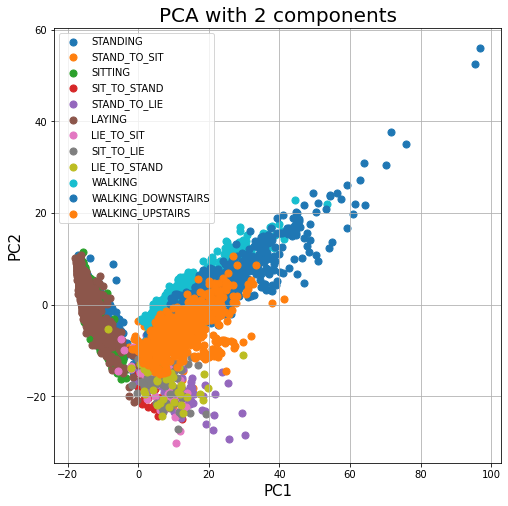

In [25]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA with 2 components', fontsize = 20)

for target in targets:
    indicesToKeep = finalDf['Activity'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , s = 50)
ax.legend(targets)
ax.grid()

In [43]:
pca.explained_variance_ratio_

array([0.48166923, 0.08132882])

From the result above we can see that the first principal component contains 48.16% of the variance and the second principal component contains 8.13% of the variance. Together, the two components contain 56.29% of the information, which is not very representative. The classes are also overlapping.

#### 3 Components PCA

In [44]:
pca3 = PCA(n_components=3)
PC3 = pca3.fit_transform(train_features)
principalDf3 = pd.DataFrame(data = PC3
             , columns = ['PC1', 'PC2', 'PC3'])

In [45]:
finalDf3 = pd.concat([principalDf3, train_labels], axis = 1)

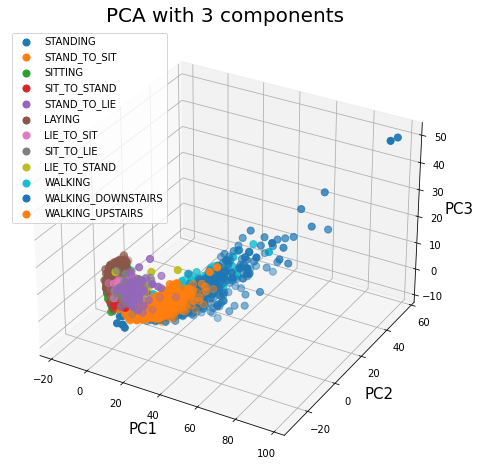

In [46]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1, projection='3d') 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_zlabel('PC3', fontsize = 15)
ax.set_title('PCA with 3 components', fontsize = 20)

for target in targets:
    indicesToKeep = finalDf3['Activity'] == target
    ax.scatter(finalDf3.loc[indicesToKeep, 'PC1']
               , finalDf3.loc[indicesToKeep, 'PC2']
               , finalDf3.loc[indicesToKeep, 'PC3']
               , s = 50)
ax.legend(targets)
ax.grid()

In [47]:
PC3.shape

(5825, 3)

In [48]:
pca3.explained_variance_ratio_

array([0.48166923, 0.08132882, 0.03218399])

From the variance ratio above we can see that the first principal component contains 48.15% of the variance and the second principal component contains 8.08% of the variance, and the third principal component contains 3.19% of the variance. Together, the three components contain 59.42% of the information, which is still considerably small. The classes are again overlapping.

In [49]:
pca_n = PCA(n_components=120)
PCN = pca_n.fit_transform(x)

In [50]:
PCN.shape

(7767, 120)

In [51]:
np.sum(pca_n.explained_variance_ratio_)

0.9633986340701681

### Isomap Embedding

In [52]:
from sklearn.manifold import Isomap as ISO

iso = ISO(n_components = 2)
isomap = iso.fit_transform(train_features)
isomapTempDf = pd.DataFrame(data = isomap, columns = ["ISO1", "ISO2"])

In [53]:
isomapFinalDf = pd.concat([isomapTempDf, train_labels], axis = 1)

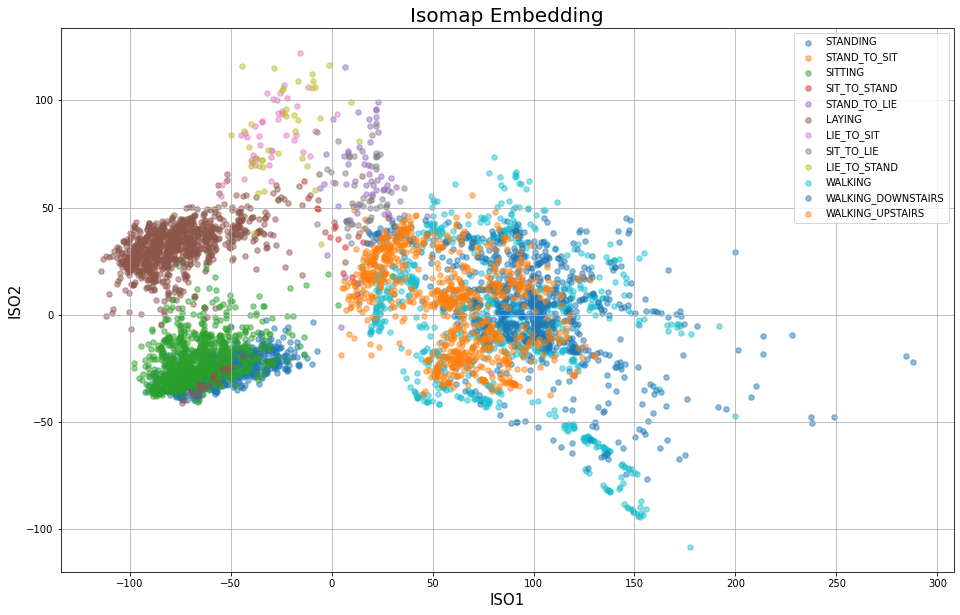

In [54]:
fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('ISO1', fontsize = 15)
ax.set_ylabel('ISO2', fontsize = 15)
ax.set_title('Isomap Embedding', fontsize = 20)

for target in targets:
    indicesToKeep = isomapFinalDf['Activity'] == target
    ax.scatter(isomapFinalDf.loc[indicesToKeep, 'ISO1']
               , isomapFinalDf.loc[indicesToKeep, 'ISO2']
               , s = 30
               , alpha = 0.5)
ax.legend(targets)
ax.grid()

In [55]:
isomap.shape

(5825, 2)

### t-Distributed Stochastic Neighbour Embedding (t-SNE)

In [56]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, perplexity = 50, n_iter = 2500)
tsne_results = tsne.fit_transform(train_features)

df_subset = pd.DataFrame(columns = ['tsne-2d-one','tsne-2d-two', 'Activities'])
df_subset['tsne-2d-one'] = tsne_results[:, 0]
df_subset['tsne-2d-two'] = tsne_results[:, 1]
df_subset['Activities'] = train_labels

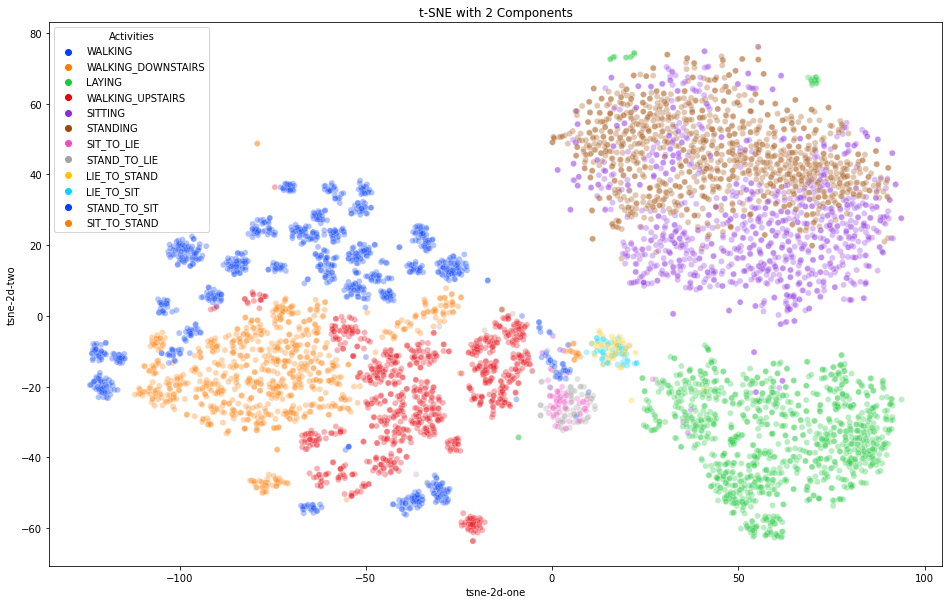

In [65]:
plt.figure(figsize = (16, 10))
plt.title('t-SNE with 2 Components')

sns.scatterplot(
    x = "tsne-2d-one", y = "tsne-2d-two",
    hue = "Activities",
    palette = "bright",
    data = df_subset,
    legend = "full",
    alpha = 0.3
)

plt.show()

# Model Training
#### First, we try to compare the training performance using various methods of dimensionality reduction
1. PCA with varying number of components
2. t-SNE
3. Isomap Embedding

1. PCA

In [26]:
from sklearn.ensemble import RandomForestClassifier as RFC

DecisionTreeClassifier()

In [27]:
# Measure the accuracy using Random Forest Classifier, number of tree = 140, maximum depth = 40, random seed = 1300
# data is transformed with PCA varying number of features for PCA

def n_PCA(n):
    pca = PCA(n_components = n, random_state = 1300)
    X_train = pca.fit_transform(train_features)
    X_validation = pca.transform(validation_features)
    return X_train, X_validation # return the transformed data both train and validation

accuracy = []

for i in range(2, 10):
    X_train, X_validation = n_PCA(i)
    y_train, y_validation = train_labels.values.ravel(), validation_labels.values.ravel()
    rfc = RFC(n_estimators = 140, max_depth = 40, random_state = 1300)
    model = rfc.fit(X_train, y_train)
    rfc_accuracy = model.score(X_validation, y_validation)
    accuracy.append([i, rfc_accuracy])
    
for i in range(10, 300, 10):
    X_train, X_validation = n_PCA(i)
    y_train, y_validation = train_labels.values.ravel(), validation_labels.values.ravel()
    rfc = RFC(n_estimators = 140, max_depth = 40, random_state = 1300)
    model = rfc.fit(X_train, y_train)
    rfc_accuracy = model.score(X_validation, y_validation)
    accuracy.append([i, rfc_accuracy])

0.8182286302780638

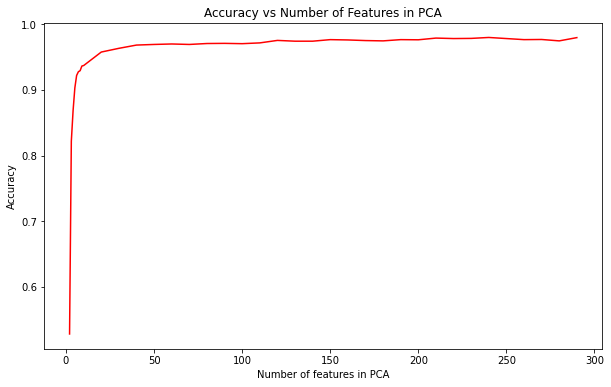

In [28]:
# Plotting the accuracy vs number of PCA features
import matplotlib.pyplot as plt

plt.figure(figsize = (10,6))
plt.plot(list(map(lambda x: x[0], accuracy)), list(map(lambda x: x[1], accuracy)), color = "r")
plt.xlabel("Number of features in PCA")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Features in PCA")
plt.show()

In [29]:
# highest accuracy with PCA

max_accuracy_PCA = max(accuracy, key = lambda x:x[1])
print("maximum accuracy attained at n = ", max_accuracy_PCA[0], "\nwith the accuracy of = ", max_accuracy_PCA[1])

maximum accuracy attained at n =  240 
with the accuracy of =  0.97990068574131


2. t-SNE

In [73]:
# data is transform using t-SNE
from sklearn.manifold import TSNE

def n_TSNE(n, perplexity):
    tsne = TSNE(n_components = n, perplexity = perplexity, n_iter = 2500, random_state = 1300)
    train_validation_combined = np.append(train_features, validation_features, axis = 0)
    X_combined = tsne.fit_transform(train_validation_combined)
    X_train, X_validation = X_combined[:len(train_features)], X_combined[len(train_features):] 
    return X_train, X_validation #return the transformed data both train and validation

# Model accuracy with Random Forest Classifier

X_train, X_validation = n_TSNE(2, 50)
y_train, y_validation = train_labels.values.ravel(), validation_labels.values.ravel()
rfc = RFC(n_estimators = 140, max_depth = 40, random_state = 1300)
model = rfc.fit(X_train, y_train)
rfc_accuracy = model.score(X_validation, y_validation)
print(rfc_accuracy)

0.9459320288362513


3. Isomap Embedding

In [11]:
# data is transformed using ISOMAP embedding
from sklearn.manifold import Isomap

def n_isomap(n, neighbors):
    iso = Isomap(n_components = n, n_neighbors = neighbors)
    X_train = iso.fit_transform(train_features)
    X_validation = iso.transform(validation_features)
    return X_train, X_validation

accuracy_isomap = []
for i in range(2, 10):
    X_train, X_validation = n_isomap(i, 5)
    y_train, y_validation = train_labels.values.ravel(), validation_labels.values.ravel()
    rfc = RFC(n_estimators = 140, max_depth = 40, random_state = 1300)
    model = rfc.fit(X_train, y_train)
    rfc_accuracy = model.score(X_validation, y_validation)
    accuracy_isomap.append(rfc_accuracy)

for i in range(10, 200, 10):
    X_train, X_validation = n_isomap(i, 5)
    y_train, y_validation = train_labels.values.ravel(), validation_labels.values.ravel()
    rfc = RFC(n_estimators = 140, max_depth = 40, random_state = 1300)
    model = rfc.fit(X_train, y_train)
    rfc_accuracy = model.score(X_validation, y_validation)
    accuracy_isomap.append(rfc_accuracy)

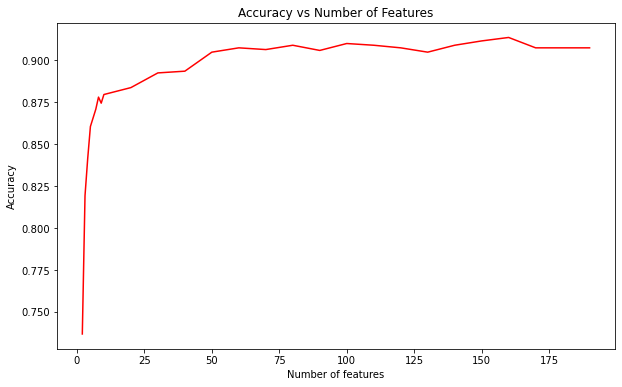

In [12]:
# Plotting the accuracy vs number of PCA features
import matplotlib.pyplot as plt

plt.figure(figsize = (10,6))
x_values = list(range(2,10)) + list(range(10, 200, 10))
plt.plot(x_values, accuracy_isomap, color = "r")
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Features")
plt.show()

In [14]:
# highest accuracy with Isomap

max_accuracy_iso = max(accuracy_isomap)
print("maximum accuracy attained at n = ", x_values[accuracy_isomap.index(max_accuracy_iso)], "\nwith the accuracy of = ", max_accuracy_iso)

maximum accuracy attained at n =  160 
with the accuracy of =  0.913491246138002


#### Next, although we know that t-SNE gives the best accuracy, we decided to use PCA with 150 components because we are more familiar with it. We will now start to train our Random Forest Classifier and try to look for the best hyperparameters. 
1. n_estimators
2. max_depth
3. max_features

In [17]:
pca = PCA(n_components=150, random_state = 1300)  
X_train = pca.fit_transform(train_features)  
X_val = pca.transform(validation_features)

In [18]:
from sklearn.tree import DecisionTreeClassifier

In [19]:
dt = DecisionTreeClassifier()
dt.fit(X_train, train_labels)

DecisionTreeClassifier()

In [20]:
dt.score(X_val, validation_labels)

0.8089598352214212

In [22]:
dt.score(X_train, train_labels)

1.0

In [41]:
from sklearn.ensemble import RandomForestClassifier

1. n_estimators

In [30]:
# Based on number of trees
clf_RF_n = [RandomForestClassifier(n_estimators = 50, random_state  = 1300),
            RandomForestClassifier(n_estimators = 150, random_state  = 1300),
            RandomForestClassifier(n_estimators = 200, random_state  = 1300),
            RandomForestClassifier(n_estimators = 400, random_state  = 1300),
            RandomForestClassifier(n_estimators = 500, random_state  = 1300),
            RandomForestClassifier(n_estimators = 600, random_state  = 1300)]

In [31]:
from sklearn.metrics import accuracy_score
from timeit import default_timer as timer

train_acc = []
acc_RF_n = []
ex_time_RF_n = []

for clf in clf_RF_n:
    start_time = timer()
    fit = clf.fit(X_train, np.ravel(train_labels))
    pred = fit.predict(X_val)
    pred2 = fit.predict(X_train)
    
    accuracy = accuracy_score(validation_labels, pred)
    accuracy2 = accuracy_score(train_labels, pred2)
    elapsed = timer() - start_time
    
    ex_time_RF_n.append(elapsed)
    train_acc.append(accuracy2)
    acc_RF_n.append(accuracy)

In [32]:
acc_RF_n

[0.9150360453141092,
 0.925849639546859,
 0.9253347064881565,
 0.9253347064881565,
 0.9284243048403708,
 0.9279093717816684]

In [33]:
train_acc

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

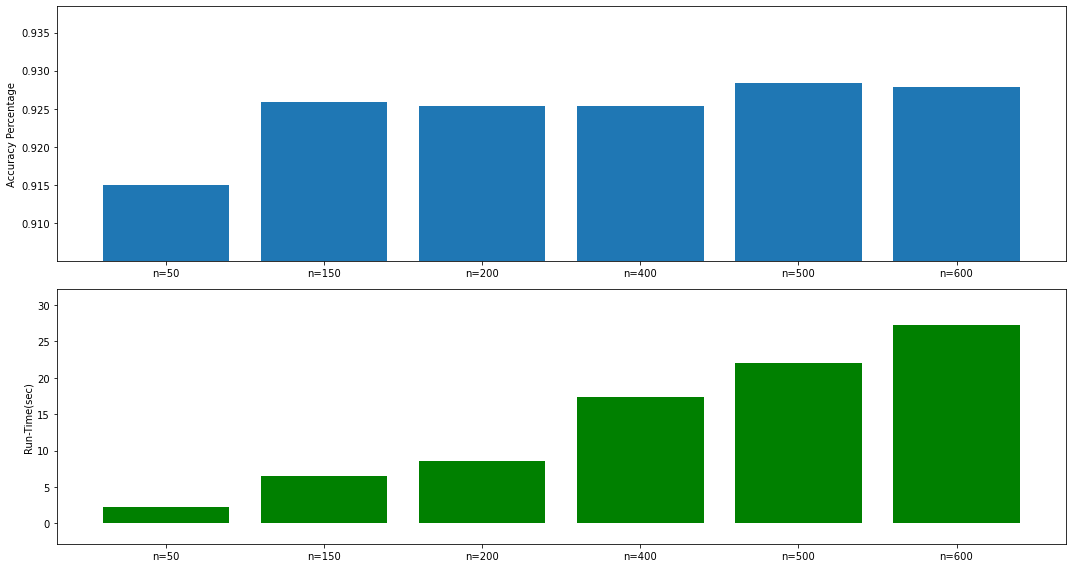

In [35]:
# Graphical Representation of ACCURACY and EXECUTION Time for RANDOM FOREST CLASSIFIER

label = ('n=50', 'n=150', 'n=200', 'n=400', 'n=500', 'n=600')
Accu = acc_RF_n
ExTime = ex_time_RF_n

plt.figure(figsize = (15,8))
y_pos = np.arange(len(label))

#Accuracy
plt.subplot(2,1,1)
plt.bar(y_pos, Accu, align='center')
plt.xticks(y_pos, label)
plt.ylim(min(Accu)- 0.01 , max(Accu) +0.01)
plt.ylabel('Accuracy Percentage')

#Execution Time
plt.subplot(2,1,2)
plt.bar(y_pos, ExTime, align='center', color = 'g')
plt.xticks(y_pos, label)
plt.ylim(min(ExTime)- 5 , max(ExTime) +5)
plt.ylabel('Run-Time(sec)')

plt.tight_layout()
plt.show()

Observation: At n = 500, we get best accuracy.
Now, we do keep n = constant and change maxium depth to 6 different levels - 10,20,40,50,70,200

2. max_depth

In [44]:
clf_RF_d = [RandomForestClassifier(n_estimators = 150, max_depth = 10, random_state  = 1300),
            RandomForestClassifier(n_estimators = 150, max_depth = 20, random_state  = 1300),
            RandomForestClassifier(n_estimators = 150, max_depth = 40, random_state  = 1300),
            RandomForestClassifier(n_estimators = 150, max_depth = 50,random_state  = 1300),
            RandomForestClassifier(n_estimators = 150, max_depth = 70, random_state  = 1300),
            RandomForestClassifier(n_estimators = 150, max_depth = 200, random_state  = 1300)]

In [45]:
ex_time_RF_d = []
acc_RF_d = []
train_acc = []

for clf in clf_RF_d :
    start_time = timer()
    fit = clf.fit(X_train, np.ravel(train_labels))
    pred = fit.predict(X_val)
    pred2 = fit.predict(X_train)

    accuracy = accuracy_score(validation_labels, pred)
    accuracy2 = accuracy_score(train_labels, pred2)
    elapsed = timer() - start_time
    
    ex_time_RF_d.append(elapsed)
    acc_RF_d.append(accuracy)
    train_acc.append(accuracy2)

In [46]:
train_acc

[0.9854077253218884, 1.0, 1.0, 1.0, 1.0, 1.0]

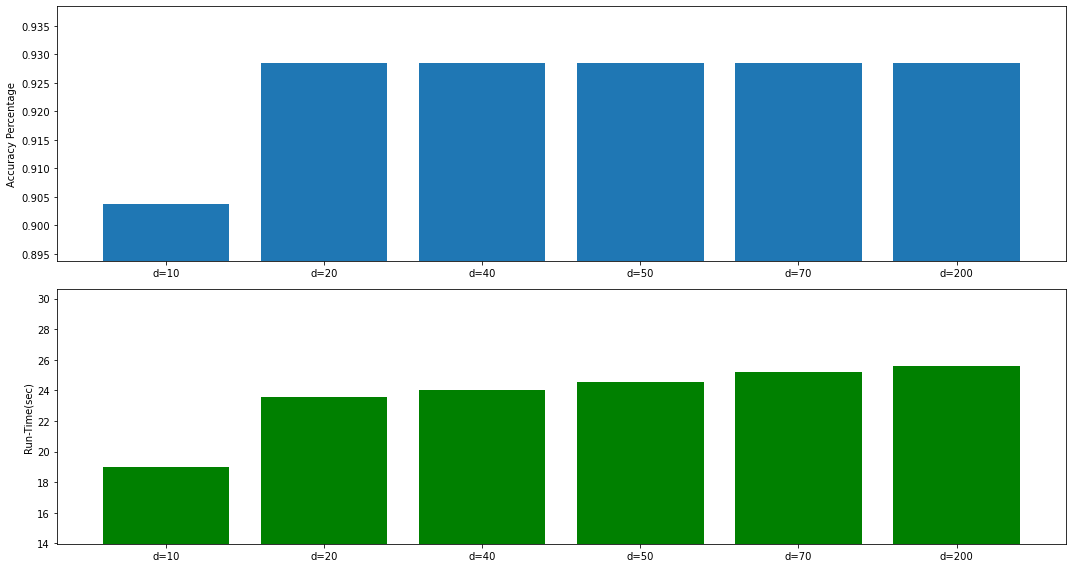

In [47]:
# Graphical Representation of ACCURACY and Execution Time for Random Forest with n = 500 and different max depths of a tree.

label = ('d=10', 'd=20', 'd=40', 'd=50', 'd=70', 'd=200')
Accu = acc_RF_d
ExTime = ex_time_RF_d

plt.figure(figsize = (15,8))
y_pos = np.arange(len(label))

#Accuracy
plt.subplot(2,1,1)
plt.bar(y_pos, Accu, align='center')
plt.xticks(y_pos, label)
plt.ylim(min(Accu)- 0.01 , max(Accu) +0.01)
plt.ylabel('Accuracy Percentage')

#Execution Time
plt.subplot(2,1,2)
plt.bar(y_pos, ExTime, align='center', color = 'g')
plt.xticks(y_pos, label)
plt.ylim(min(ExTime)- 5 , max(ExTime) +5)
plt.ylabel('Run-Time(sec)')

plt.tight_layout()
plt.show()

Observation: depth above 20 has no improvements in scores
Now, we can keep max depth of 20 and n = 500 constant and change maximum number of features to consider to log2, sqrt and considering all n features.

3. max_features

In [49]:
RF_f_n = 150
RF_f_d = 20

clf_RF_f = [RandomForestClassifier(n_estimators = RF_f_n, max_depth = RF_f_d, max_features= 'log2', random_state  = 1300),
            RandomForestClassifier(n_estimators = RF_f_n, max_depth = RF_f_d, max_features= 'sqrt',random_state  = 1300),
            RandomForestClassifier(n_estimators = RF_f_n, max_depth = RF_f_d, max_features= None,random_state  = 1300)]

In [50]:
ex_time_RF_f = []
acc_RF_f = []
train_acc = []

for clf in clf_RF_f :
    start_time = timer()
    fit = clf.fit(X_train, np.ravel(train_labels))
    pred = fit.predict(X_val)
    pred2 = fit.predict(X_train)

    accuracy = accuracy_score(validation_labels, pred)
    accuracy2 = accuracy_score(train_labels, pred2)
    elapsed = timer() - start_time
    
    ex_time_RF_f.append(elapsed)
    acc_RF_f.append(accuracy)
    train_acc.append(accuracy2)

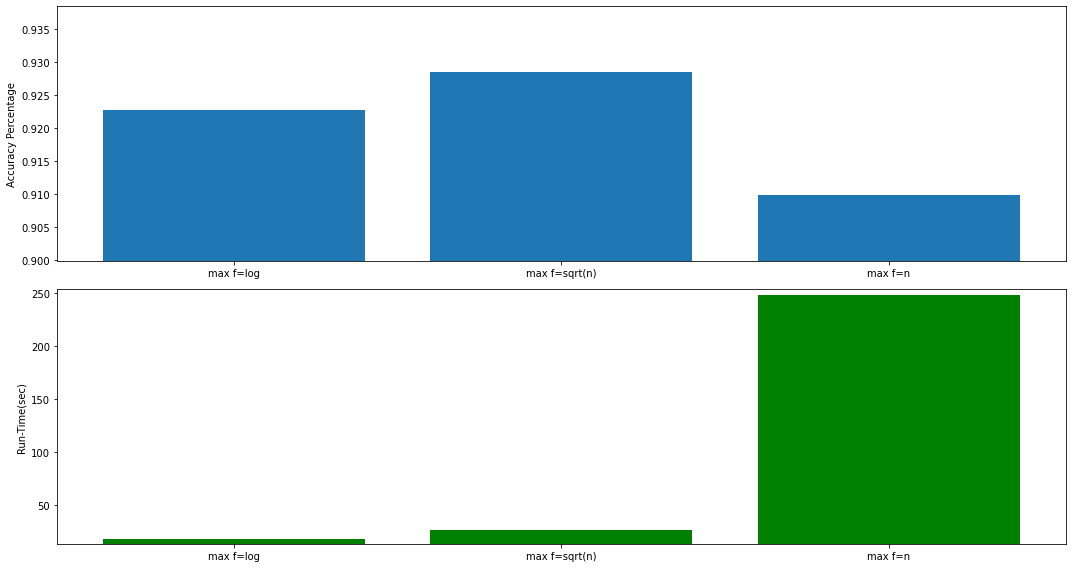

In [52]:
# Graphical Representation of ACCURACY and Execution Time for Random Forest with n = 600, max depth = 20 and different max features.

label = ('max f=log','max f=sqrt(n)','max f=n')
Accu = acc_RF_f
ExTime = ex_time_RF_f

plt.figure(figsize = (15,8))
y_pos = np.arange(len(label))

#Accuracy
plt.subplot(2,1,1)
plt.bar(y_pos, Accu, align='center')
plt.xticks(y_pos, label)
plt.ylim(min(Accu)- 0.01 , max(Accu) +0.01)
plt.ylabel('Accuracy Percentage')

#Execution Time
plt.subplot(2,1,2)
plt.bar(y_pos, ExTime, align='center', color = 'g')
plt.xticks(y_pos, label)
plt.ylim(min(ExTime)- 5 , max(ExTime) +5)
plt.ylabel('Run-Time(sec)')

plt.tight_layout()
plt.show()

In [55]:
train_acc

[1.0, 1.0, 1.0]

Observation: After making 2 hyperparameters constant and chaning maximum featuers, we can find that performance of Radom Forest is best for hyperparameter, maximum depth at sqrt(n)

## Comparing RF Performance on PCA Data Before and After Handling Imbalance Data

In [18]:
# Import necessary package
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from timeit import default_timer as timer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

### Random Forest Performance on PCA of Original Data

In [16]:
# First, we need to standardize the data to get better performance
features = train.columns.values.tolist()
features.remove('Activity')
features.remove('subject')

# Separating out the features
x = train.loc[:, features].values

# Separating out the target
y = train.loc[:,['Activity']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

train_features, validation_features, train_labels, validation_labels = train_test_split(x, y, test_size=0.25, random_state=1300)

targets = train['Activity'].unique()

train_labels = pd.DataFrame(train_labels, columns=['Activity'])
validation_labels = pd.DataFrame(validation_labels, columns=['Activity'])

In [17]:
pca = PCA(n_components=150, random_state = 1300)  
X_train = pca.fit_transform(train_features)  
X_val = pca.transform(validation_features) 

In [18]:
clf = RandomForestClassifier(n_estimators = 500, max_depth = 20, max_features= 'sqrt', random_state  = 1300)

start_time = timer()
fit = clf.fit(X_train, np.ravel(train_labels))
pred = fit.predict(X_val)

# Activity label
activity_label = pd.Series(test.Activity.values).unique()

# Get evaluation metric
accuracy = accuracy_score(validation_labels, pred)
elapsed = timer() - start_time
f1 = f1_score(validation_labels, pred, average = None, labels = activity_label)
avgf1 = f1_score(validation_labels, pred, average = "micro") # Using micro as labels are under represented
recall = recall_score(validation_labels, pred, average = None, labels = activity_label)
avgrecall = recall_score(validation_labels, pred, average = "micro") # Using micro as labels are under represented
precision = precision_score(validation_labels, pred, average = None, labels = activity_label)
avgprec = precision_score(validation_labels, pred, average = "micro") # Using micro as labels are under represented

print("Accuracy of validation Set: ", accuracy)
print("Average Precision Score of validation Set: ", avgprec)
print("Average Recall Score of validation Set: ", avgrecall)
print("Average F1 Score of validation Set: ", avgf1)
print("Run Time of validation Set:", elapsed)

Accuracy of validation Set:  0.9284243048403708
Average Precision Score of validation Set:  0.9284243048403708
Average Recall Score of validation Set:  0.9284243048403708
Average F1 Score of validation Set:  0.9284243048403708
Run Time of validation Set: 21.283891900000015


## Handling Imbalance Data with Over Sampling
### 1. SMOTE
#### Add synthetic data

In [12]:
from imblearn.over_sampling import SMOTE

# Separating out the features for training data
features = train.columns.values.tolist()
features.remove('Activity')
features.remove('subject')

# Separating out the features
x = train.loc[:, features].values

# Separating out the target
y = train.loc[:,['Activity']].values

# Separating out the features for test data
test_features = test.columns.values.tolist()
test_features.remove('Activity')
test_features.remove('subject')

x_test = test.loc[:, test_features].values
y_test = test.loc[:,['Activity']].values

train_features, validation_features, train_labels, validation_labels = train_test_split(x, y, test_size=0.25, random_state=1300)

# applying smote on training and test data
smt = SMOTE()
xtrain_sm, ytrain_sm = smt.fit_resample(train_features, train_labels)

# Standardizing the features
sc = StandardScaler()
xtrain_sm = sc.fit_transform(xtrain_sm)
validation_features = sc.transform(validation_features)

train_labels = pd.DataFrame(ytrain_sm, columns=['Activity'])
validation_labels = pd.DataFrame(validation_labels, columns=['Activity'])

#### Perform PCA on SMOTE Data

In [15]:
pca = PCA(n_components=150, random_state = 1300)  
X_train = pca.fit_transform(xtrain_sm)  
X_val = pca.transform(validation_features) 

#### Perform Random Forest on PCA SMOTE Data

In [19]:
clf = RandomForestClassifier(n_estimators = 500, max_depth = 20, max_features= 'sqrt', random_state  = 1300)

start_time = timer()
fit = clf.fit(X_train, np.ravel(ytrain_sm))
pred = fit.predict(X_val)

# Activity label
activity_label = pd.Series(test.Activity.values).unique()

# Get evaluation metric
accuracy = accuracy_score(validation_labels, pred)
elapsed = timer() - start_time
f1 = f1_score(validation_labels, pred, average = None, labels = activity_label)
avgf1 = f1_score(validation_labels, pred, average = "micro") #Using micro as labels are under represented
recall = recall_score(validation_labels, pred, average = None, labels = activity_label)
avgrecall = recall_score(validation_labels, pred, average = "micro") #Using micro as labels are under represented
precision = precision_score(validation_labels, pred, average = None, labels = activity_label)
avgprec = precision_score(validation_labels, pred, average = "micro") #Using micro as labels are under represented

print("Accuracy of feature Set: ", accuracy)
print("Average Precision Score of feature Set: ", avgprec)
print("Average Recall Score of feature Set: ", avgrecall)
print("Average F1 Score of feature Set: ", avgf1)
print("Run Time of feature Set:", elapsed)

Accuracy of feature Set:  0.9325437693099897
Average Precision Score of feature Set:  0.9325437693099897
Average Recall Score of feature Set:  0.9325437693099897
Average F1 Score of feature Set:  0.9325437693099897
Run Time of feature Set: 47.00221139999985


### 2. ADASYN
#### Add synthetic data

In [23]:
from imblearn.over_sampling import ADASYN 

# Separating out the features for training data
features = train.columns.values.tolist()
features.remove('Activity')
features.remove('subject')

# Separating out the features
x = train.loc[:, features].values

# Separating out the target
y = train.loc[:,['Activity']].values

# applying smote on training and test data
adasyn = ADASYN()
xtrain_ad, ytrain_ad = adasyn.fit_resample(x, y)

# Standardizing the features
xtrain_ad = StandardScaler().fit_transform(xtrain_ad)

train_features, validation_features, train_labels, validation_labels = train_test_split(xtrain_ad, ytrain_ad, test_size=0.25, random_state=1300)

train_labels = pd.DataFrame(train_labels, columns=['Activity'])
validation_labels = pd.DataFrame(validation_labels, columns=['Activity'])

#### Perform PCA on ADASYN Data  

In [24]:
pca = PCA(n_components=150, random_state = 1300)  
X_train = pca.fit_transform(train_features)  
X_val = pca.transform(validation_features) 

#### Perform Random Forest on PCA ADASYN Data

In [25]:
clf = RandomForestClassifier(n_estimators = 500, max_depth = 20, max_features= 'sqrt', random_state  = 1300)

start_time = timer()
fit = clf.fit(X_train, np.ravel(train_labels))
pred = fit.predict(X_val)

# Activity label
activity_label = pd.Series(test.Activity.values).unique()

# Get evaluation metric
accuracy = accuracy_score(validation_labels, pred)
elapsed = timer() - start_time
f1 = f1_score(validation_labels, pred, average = None, labels = activity_label)
avgf1 = f1_score(validation_labels, pred, average = "micro") #Using micro as labels are under represented
recall = recall_score(validation_labels, pred, average = None, labels = activity_label)
avgrecall = recall_score(validation_labels, pred, average = "micro") #Using micro as labels are under represented
precision = precision_score(validation_labels, pred, average = None, labels = activity_label)
avgprec = precision_score(validation_labels, pred, average = "micro") #Using micro as labels are under represented

print("Accuracy of feature Set: ", accuracy)
print("Average Precision Score of feature Set: ", avgprec)
print("Average Recall Score of feature Set: ", avgrecall)
print("Average F1 Score of feature Set: ", avgf1)
print("Run Time of feature Set:", elapsed)

Accuracy of feature Set:  0.9782454480964767
Average Precision Score of feature Set:  0.9782454480964767
Average Recall Score of feature Set:  0.9782454480964767
Average F1 Score of feature Set:  0.9782454480964767
Run Time of feature Set: 48.06676399999998


# Feature Selection / Extraction

1. Using Recursive Feature Elimination

In [121]:
#Import package used

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from timeit import default_timer as timer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE

### (a) RFE on the initial data

We will first run RFE on the initial data to see how it performs compared to the other methods to reduce dimensionality

In [122]:
# Reimporting data to ensure that the data isn't manipulated else where
train = pd.read_csv("./input/Train/train.csv")
test = pd.read_csv("./input/Test/test.csv")

# First, we need to filter the data
features = train.columns.values.tolist()
features.remove('Activity')
features.remove('subject') #remove subject as its a categorical feature

# Separating out the features
x = train.loc[:, features].values

# Separating out the target
y = train['Activity']

# Splitting the data into Validation and Train before processing
train_features, validation_features, train_labels, validation_labels = train_test_split(x, y, test_size=0.25, random_state=1300)

# List of labels
activity_label = pd.Series(test.Activity.values).unique()

activity_label_fixed = ['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS']

activity_label_moving = ['STAND_TO_SIT', 'SIT_TO_STAND',
       'STAND_TO_LIE', 'LIE_TO_SIT', 'SIT_TO_LIE',
       'LIE_TO_STAND']

In [23]:
#Use RandomForest to do the recursive feature elimination with 5-fold k fold validation

# This model was hyper parameter tuned for the initial data
model = RandomForestClassifier(n_estimators = 150, max_depth = 20, max_features= 'sqrt',random_state  = 1300)

# Use timer to see how long this will take to run
# Run RFECV with the model to determine the best features
start_time = timer()
rfecv = RFECV(model, step = 10, scoring = 'f1_macro', cv = 5) # Using f1_macro as the initial data has imbalanced data
selector_cv = rfecv.fit(train_features, train_labels)
elapsed_time = timer() - start_time

In [ ]:
print(elapsed_time)
print(selector_cv.n_features_) #131 is the number of features suggested selected by the RFECV

After running the RFECV, we shall plot the score of the model against the number of feature.
Whille n = 131 is where the f1 score is the highest, we will use the plot to see if there is a point on the graph to determine the optimal number of features to be selected (E.g the score saturates even with more features)

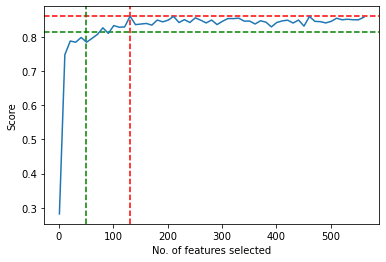

In [6]:
#Plotting the Score against the number of feature selected

plt.figure()
plt.xlabel("No. of features selected")
plt.ylabel("Score")
plt.axvline(x=131, color='r', linestyle = '--') #The point where the feature seems to saturate 
plt.axhline(y=0.86, color='r', linestyle= '--')
plt.axvline(x=50, color='g', linestyle = '--') #The elbow start
plt.axhline(y=0.815, color='g', linestyle= '--') #The elbow start
plt.plot(
 range(1, 562, 10),
    selector_cv.grid_scores_,
)

Based on the above, it seems like the elbow is around where n = 50 but the graph seems to start saturating from around 120 features onwards. So we shall select n = 131

In [19]:
#Use RandomForest to do the recursive feature elimination and select the best 131
 
model = RandomForestClassifier(n_estimators = 150, max_depth = 20, max_features= 'sqrt',random_state  = 1300)

# Use timer to see how long this will take to run
# Run RFE with the model to determine the best 131 features
start_time = timer()
rfe = RFE(model, n_features_to_select = 131, step = 10) #n = 131 from the analysis above
selector_cv2 = rfe.fit(train_features, train_labels)

elapsed_time = timer() - start_time

In [30]:
#List of the 131 features selected by RFE
print(selected_features)

['tBodyAcc-Mean-1                ' 'tBodyAcc-Mean-2                '
 'tBodyAcc-Mean-3                ' 'tBodyAcc-STD-1                 '
 'tBodyAcc-Mad-1                 ' 'tBodyAcc-Max-1                 '
 'tBodyAcc-Max-2                 ' 'tBodyAcc-Min-1                 '
 'tBodyAcc-SMA-1                 ' 'tBodyAcc-Energy-1              '
 'tBodyAcc-Energy-2              ' 'tBodyAcc-IQR-1                 '
 'tBodyAcc-ropy-1                ' 'tBodyAcc-ropy-1                .1'
 'tBodyAcc-ropy-1                .2' 'tBodyAcc-Correlation-1         '
 'tBodyAcc-Correlation-2         ' 'tBodyAcc-Correlation-3         '
 'tGravityAcc-Mean-1             ' 'tGravityAcc-Mean-2             '
 'tGravityAcc-Mean-3             ' 'tGravityAcc-STD-1              '
 'tGravityAcc-STD-2              ' 'tGravityAcc-STD-3              '
 'tGravityAcc-Mad-1              ' 'tGravityAcc-Mad-2              '
 'tGravityAcc-Mad-3              ' 'tGravityAcc-Max-1              '
 'tGravityAcc-Max-2           

## Evaluation for the selected 131 features for the inital data
So with this 131 features, we shall test the selected features to see how well it performs

In [ ]:
#transform the data to only have the 131 selected features
x_rfecv_131 = selector_cv2.transform(train_features)

xval_rfecv_131 = selector_cv2.transform(validation_features)

selected_features = np.array(features)[selector_cv2.support_]

In [22]:
clf = RandomForestClassifier(n_estimators = 150, max_depth = 20, max_features= 'sqrt',random_state  = 1300)

start_time = timer()
fit = clf.fit(x_rfecv_131, train_labels)
pred = fit.predict(xval_rfecv_131)

#Get evaluation metric
accuracy = accuracy_score(validation_labels, pred)
elapsed = timer() - start_time
f1 = f1_score(validation_labels, pred, average = None, labels = activity_label)
avgf1 = f1_score(validation_labels, pred, average = "micro") #Using micro as labels are under represented
recall = recall_score(validation_labels, pred, average = None, labels = activity_label)
avgrecall = recall_score(validation_labels, pred, average = "micro") #Using micro as labels are under represented
precision = precision_score(validation_labels, pred, average = None, labels = activity_label)
avgprec = precision_score(validation_labels, pred, average = "micro") #Using micro as labels are under represented

In [8]:
print("Accuracy of feature Set: ", accuracy)
print("Average Precision Score of feature Set: ", avgprec)
print("Average Recall Score of feature Set: ", avgrecall)
print("Average F1 Score of feature Set: ", avgf1)
print("Run Time of feature Set:", elapsed)

Accuracy of feature Set:  0.9742533470648815
Average Precision Score of feature Set:  0.9742533470648815
Average Recall Score of feature Set:  0.9742533470648815
Average F1 Score of feature Set:  0.9742533470648815
Run Time of feature Set: 11.63270939999984


In [ ]:
pd.DataFrame([f1] + [recall] + [precision], columns = activity_label, index = ["F1 Score", "Recall Score", "Precision Score"])

### (b) RFE on Smote Data

We also perform RFE on the Smote Data to reduce its dimensionality

In [ ]:
# Reimporting data to ensure that the data isn't manipulated else where
train = pd.read_csv("./input/Train/train.csv")
test = pd.read_csv("./input/Test/test.csv")

# First, we need to filter the data
features = train.columns.values.tolist()
features.remove('Activity')
features.remove('subject') #remove subject as its a categorical feature

# Separating out the features
x = train.loc[:, features].values

# Separating out the target
y = train['Activity']

# Splitting the data into Validation and Train before processing
train_features, validation_features, train_labels, validation_labels = train_test_split(x, y, test_size=0.25, random_state=1300)

# List of labels
activity_label = pd.Series(test.Activity.values).unique()

activity_label_fixed = ['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS']

activity_label_moving = ['STAND_TO_SIT', 'SIT_TO_STAND',
       'STAND_TO_LIE', 'LIE_TO_SIT', 'SIT_TO_LIE',
       'LIE_TO_STAND']

In [ ]:
# applying smote on training set
smt = SMOTE()
train_features, train_labels = smt.fit_resample(train_features, train_labels)

In [ ]:
# Use RandomForest to do the recursive feature elimination with 5-fold k fold validation

# This model was hyper parameter tuned for the smote data
model = RandomForestClassifier(n_estimators = 150, max_depth = 20, max_features= 'sqrt',random_state = 1300)

# Use timer to see how long this will take to run
# Run RFECV with the model to determine the best features
start_time = timer()
rfecv = RFECV(model, step = 10, scoring = 'accuracy', cv = 5) #Using accuracy since the smote data is not imbalanced
selector_cv_smote = rfecv.fit(train_features, train_labels)
elapsed_time = timer() - start_time

In [ ]:
print(elapsed_time)
print(selector_cv_smote.n_features_) #441 is the number of features suggested selected by the RFECV

After running the RFECV, we shall plot the score of the model against the number of feature.
Whille n = 441 is where the accuracy is the highest, we will use the plot to see if there is a point on the graph to determine the optimal number of features to be selected (E.g the score saturates even with more features)

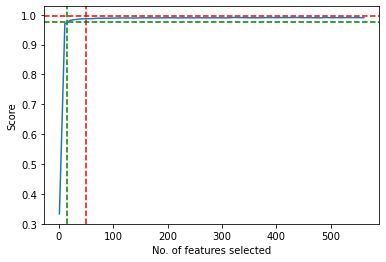

In [10]:
#Plotting the Score against the number of feature selected

plt.figure()
plt.xlabel("No. of features selected")
plt.ylabel("Score")
plt.axvline(x=50, color='r', linestyle = '--') #The point where the feature seems to saturate 
plt.axhline(y=0.995, color='r', linestyle= '--')
plt.axvline(x=15, color='g', linestyle = '--') #The elbow start
plt.axhline(y=0.9755, color='g', linestyle= '--') #The elbow start
plt.plot(
 range(1, 562, 10),
    selector_cv_smote.grid_scores_,
)

Based on the above, it seems like the elbow is around where n = 15 and the graph clearly start saturating from around 30-50 features onwards. So we shall select n = 50

In [ ]:
#Use RandomForest to do the recursive feature elimination and select the best 50
 
model = RandomForestClassifier(n_estimators = 150, max_depth = 20, max_features= 'sqrt',random_state  = 1300)

# Use timer to see how long this will take to run
# Run RFE with the model to determine the best 25 features
start_time = timer()
rfe = RFE(model, n_features_to_select = 50, step = 10) #n = 50 from the analysis above
selector_cv_smote = rfe.fit(train_features, train_labels)
elapsed_time = timer() - start_time

## Evaluation for the selected 50 features for the smoted data
So with this 50 features, we shall test the selected features to see how well it performs

In [ ]:
#transform the data to only have the 50 selected features
x_rfecv_50 = selector_cv_smote.transform(train_features)

xval_rfecv_50 = selector_cv_smote.transform(validation_features)

selected_features = np.array(features)[selector_cv_smote.support_]

In [ ]:
#List of the 50 features selected by RFE
print(selected_features)

In [23]:
clf = RandomForestClassifier(n_estimators = 150, max_depth = 20, max_features= 'sqrt',random_state  = 1300)

start_time = timer()
fit = clf.fit(x_rfecv_50, train_labels)
pred = fit.predict(xval_rfecv_50)

#Get evaluation metric
accuracy = accuracy_score(validation_labels, pred)
elapsed = timer() - start_time
f1 = f1_score(validation_labels, pred, average = None, labels = activity_label)
avgf1 = f1_score(validation_labels, pred, average = "micro") #Using micro as labels are under represented
recall = recall_score(validation_labels, pred, average = None, labels = activity_label)
avgrecall = recall_score(validation_labels, pred, average = "micro") #Using micro as labels are under represented
precision = precision_score(validation_labels, pred, average = None, labels = activity_label)
avgprec = precision_score(validation_labels, pred, average = "micro") #Using micro as labels are under represented

In [12]:
print("Accuracy of feature Set: ", accuracy)
print("Average Precision Score of feature Set: ", avgprec)
print("Average Recall Score of feature Set: ", avgrecall)
print("Average F1 Score of feature Set: ", avgf1)
print("Run Time of feature Set:", elapsed)

Accuracy of feature Set:  0.970648815653965
Average Precision Score of feature Set:  0.970648815653965
Average Recall Score of feature Set:  0.970648815653965
Average F1 Score of feature Set:  0.970648815653965
Run Time of feature Set: 3.412473799999134


In [ ]:
pd.DataFrame([f1] + [recall] + [precision], columns = activity_label, index = ["F1 Score", "Recall Score", "Precision Score"])

2. Using Correlation

First check if there are any constant/quasi constant features as their variance will be near or = 0


In [ ]:
# First, we need to standardize the data to get better performance
features = train.columns.values.tolist()
features.remove('Activity')
features.remove('subject') #remove subject as its a categorical feature

# Separating out the features
x = train.loc[:, features].values

# Separating out the target
y = train['Activity']

# Standardizing the features
x = StandardScaler().fit_transform(x)

train_features, validation_features, train_labels, validation_labels = train_test_split(x, y, test_size=0.25, random_state=1300)

#train_labels = pd.DataFrame(train_labels, columns=['Activity'])
#validation_labels = pd.DataFrame(validation_labels, columns=['Activity'])

#List of labels
activity_label = pd.Series(test.Activity.values).unique()

activity_label_fixed = ['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS']

activity_label_moving = ['STAND_TO_SIT', 'SIT_TO_STAND',
       'STAND_TO_LIE', 'LIE_TO_SIT', 'SIT_TO_LIE',
       'LIE_TO_STAND']

In [106]:
#Variance 0 means constant
check_constant = VarianceThreshold(0)
check_constant.fit(train_features)

VarianceThreshold(threshold=0)

In [107]:
check_constant.get_support().sum() # = 561, so no constant features dropped

561

In [108]:
#Next check for quasi constant (values are very close and is likely noise)

check_quasi = VarianceThreshold(0.01)
check_quasi.fit(train_features)

VarianceThreshold(threshold=0.01)

In [109]:
check_quasi.get_support().sum() # = 561, so no quasi features dropped

561

In [110]:
#Next check for duplicates

dup = pd.DataFrame(train_features)
dup.duplicated().sum() # = 0, so no duplicates as well

0

In [111]:
corrmat = pd.DataFrame(train_features, columns = features).corr()

In [112]:
#Viewing the correlations
corrmat

,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-STD-1,tBodyAcc-STD-2,tBodyAcc-STD-3,tBodyAcc-Mad-1,tBodyAcc-Mad-2,tBodyAcc-Mad-3,tBodyAcc-Max-1,...,fBodyGyroJerkMag-MeanFreq-1,fBodyGyroJerkMag-Skewness-1,fBodyGyroJerkMag-Kurtosis-1,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1,tXAxisAcc-AngleWRTGravity-1,tYAxisAcc-AngleWRTGravity-1,tZAxisAcc-AngleWRTGravity-1
tBodyAcc-Mean-1,1.000000,-0.603429,-0.627242,0.021005,-0.030296,-0.046449,0.027704,-0.034368,-0.052074,0.144404,...,0.020836,-0.031208,-0.027451,-0.139288,0.019357,-0.057934,0.036937,0.121258,-0.090461,-0.081239
tBodyAcc-Mean-2,-0.603429,1.000000,0.453520,-0.018774,0.043076,0.072398,-0.019689,0.051338,0.084481,-0.103923,...,-0.024978,0.026362,0.022893,0.050021,0.024509,0.073600,0.020952,-0.089735,0.077405,0.042830
tBodyAcc-Mean-3,-0.627242,0.453520,1.000000,-0.011024,0.059024,0.077984,-0.011945,0.069157,0.090020,-0.097933,...,-0.017027,0.037530,0.035063,0.033380,0.012061,0.017697,-0.015212,-0.074793,0.031936,0.070395
tBodyAcc-STD-1,0.021005,-0.018774,-0.011024,1.000000,0.878006,0.802006,0.998285,0.857617,0.781982,0.969201,...,-0.063772,0.131639,0.098865,-0.025073,-0.015009,-0.001405,-0.011616,-0.342445,0.421600,0.367638
tBodyAcc-STD-2,-0.030296,0.043076,0.059024,0.878006,1.000000,0.872037,0.873351,0.996098,0.865693,0.846435,...,-0.140626,0.196486,0.166231,0.016232,0.025059,-0.014549,0.004560,-0.332680,0.424474,0.374979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tBodyGyro-AngleWRTGravity-1,-0.057934,0.073600,0.017697,-0.001405,-0.014549,-0.021541,-0.001775,-0.015690,-0.024717,-0.000902,...,-0.028657,0.039093,0.029295,0.003721,0.024965,1.000000,-0.106322,-0.015456,-0.007042,-0.018208
tBodyGyroJerk-AngleWRTGravity-1,0.036937,0.020952,-0.015212,-0.011616,0.004560,0.010081,-0.011316,0.007779,0.011184,-0.012261,...,-0.003795,-0.008724,-0.008208,-0.022656,0.018381,-0.106322,1.000000,0.022398,-0.004230,0.001644
tXAxisAcc-AngleWRTGravity-1,0.121258,-0.089735,-0.074793,-0.342445,-0.332680,-0.300182,-0.335911,-0.321707,-0.293672,-0.347605,...,0.085365,-0.069728,-0.064926,0.028402,0.049221,-0.015456,0.022398,1.000000,-0.784688,-0.649072
tYAxisAcc-AngleWRTGravity-1,-0.090461,0.077405,0.031936,0.421600,0.424474,0.385973,0.413500,0.412385,0.374398,0.432251,...,-0.081224,0.061907,0.054803,-0.025324,-0.049949,-0.007042,-0.004230,-0.784688,1.000000,0.592048


<AxesSubplot:>

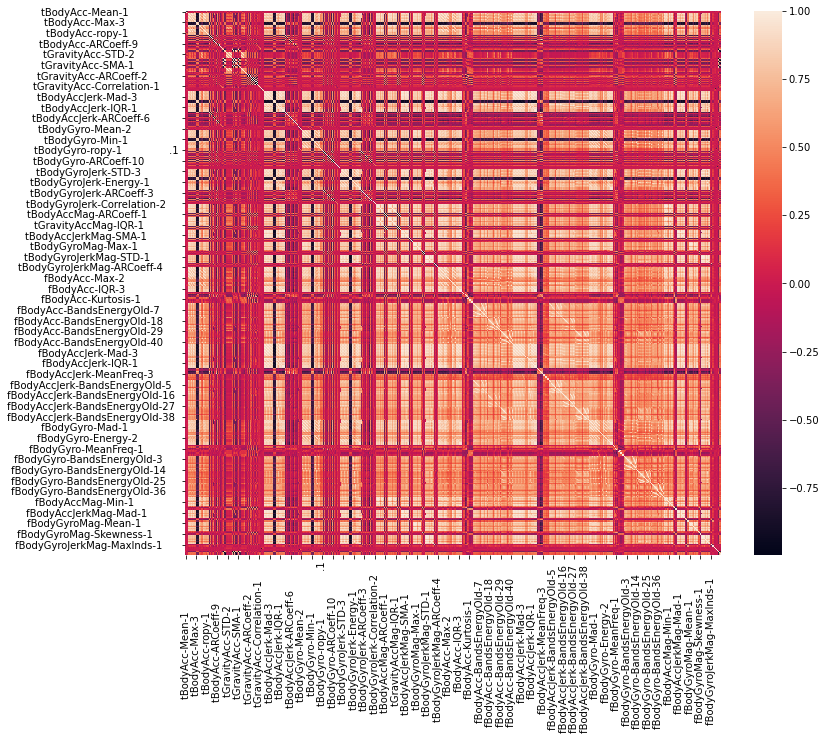

In [113]:
#Plotting the correlation as a heatmap for a better visualization
plt.figure(figsize = (12,10))
sns.heatmap(corrmat)

In [114]:
# Define a function to filter out the features that are highly correlated to each other

def get_high_corr(cormat, th):
    high_corr_feature = set()
    for i in range(len(cormat)):
        for j in range(i):
            if abs(cormat.iloc[i,j]) >= th and not (cormat.columns[j] in high_corr_feature):
                cname = cormat.columns[i]
                high_corr_feature.add(cname)
    return high_corr_feature

In [115]:
#Use the function to get the list of highly correlated features

high_corr_features = get_high_corr(corrmat, 0.85)

In [116]:
len(high_corr_features) # = 353 highyly correlated features

353

In [117]:
#Drop these highly correlated features

filtered_train_features = pd.DataFrame(train_features, columns = features).drop(labels = high_corr_features, axis = 1)
filtered_val_features = pd.DataFrame(validation_features, columns = features).drop(labels = high_corr_features, axis = 1)

In [118]:
filtered_train_features

,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-STD-1,tBodyAcc-STD-3,tBodyAcc-Max-2,tBodyAcc-Energy-2,tBodyAcc-Energy-3,tBodyAcc-ropy-1,tBodyAcc-ropy-1 .1,...,fBodyGyroMag-MeanFreq-1,fBodyGyroMag-Skewness-1,fBodyGyroJerkMag-Min-1,fBodyGyroJerkMag-MaxInds-1,fBodyGyroJerkMag-MeanFreq-1,fBodyGyroJerkMag-Skewness-1,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1
0,0.260026,-0.242860,-0.157751,0.733960,0.258625,1.709412,1.235210,-0.170307,1.139477,1.116462,...,1.811046,-1.300497,0.723829,-0.007032,0.624445,-0.295009,-1.800179,1.538029,0.208321,1.715255
1,-0.284268,0.405699,0.103783,2.480425,0.664900,0.878212,0.888883,0.097550,0.871166,1.466546,...,0.544042,-0.509654,1.737584,0.224408,0.658337,0.829333,1.328875,-0.812206,-1.552341,1.279975
2,0.030248,0.007598,-0.031466,-0.886333,-0.901742,-0.861308,-0.616316,-0.527087,-0.566370,-0.632048,...,-0.691760,0.341142,-0.630735,1.613048,0.467035,-0.833657,-0.418885,-0.354278,0.390561,0.711132
3,0.160840,0.161994,0.286832,0.300691,0.778662,0.541918,-0.005751,0.192021,1.078632,1.080637,...,-0.260963,-1.150839,-0.011153,-0.007032,0.257311,-0.678368,0.070149,-1.225722,1.594955,1.783328
4,-0.018887,-0.361360,-0.190919,0.933449,2.102830,1.822701,0.740999,1.649044,1.040282,0.381939,...,1.079471,-1.136067,1.226479,-0.469912,0.886852,-1.183016,-0.632384,0.723734,-0.494347,-0.748341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5820,0.002507,-0.004805,0.023918,-0.904867,-0.940071,-0.924386,-0.617662,-0.528339,-1.335746,-1.156397,...,0.078721,1.553981,-0.631356,0.918728,1.627432,-1.181845,0.191904,-0.304795,0.648256,1.076969
5821,0.052060,0.071545,0.096323,-0.808955,-0.732980,-0.642313,-0.593930,-0.512392,0.186030,0.283117,...,-0.611085,-0.600223,-0.429283,-0.238472,-1.384516,-0.807284,0.193013,-1.112972,-0.231584,-0.122461
5822,0.251092,0.094365,-0.241231,0.734108,0.293018,1.207966,0.798262,-0.148071,0.990062,0.996066,...,0.665882,-0.422444,1.150675,0.224408,0.698754,-0.388448,-1.335116,1.741819,1.551738,1.993707
5823,-0.002990,-0.025961,0.040338,-0.901444,-0.932874,-0.921952,-0.617424,-0.528023,-1.267566,-1.161498,...,0.995572,-1.583958,-0.656001,-0.007032,0.343704,-0.815170,0.102962,-0.866637,-0.395750,0.423012


In [147]:
#Checking the model with the uncorrelated features

clf = RandomForestClassifier(n_estimators = 150, max_depth = 40, max_features= 'log2', random_state = 1300)

start_time = timer()
fit_2 = clf.fit(filtered_train_features, train_labels)
pred_2 = fit_2.predict(filtered_val_features)

#Get evaluation metric
accuracy_2 = accuracy_score(validation_labels, pred_2)
elapsed2 = timer() - start_time
f1_2 = f1_score(validation_labels, pred_2, average = None, labels = activity_label)
avgf1_2 = f1_score(validation_labels, pred_2, average = "micro") #Using micro as labels are under represented
recall_2 = recall_score(validation_labels, pred_2, average = None, labels = activity_label)
avgrecall_2 = recall_score(validation_labels, pred_2, average = "micro") #Using micro as labels are under represented
precision_2 = precision_score(validation_labels, pred_2, average = None, labels = activity_label)
avgprec_2 = precision_score(validation_labels, pred_2, average = "micro") #Using micro as labels are under represented

In [143]:
print("Accuracy of uncorrelated Set: ", accuracy_2)
print("Average Precision Score of uncorrelated Set: ", avgprec_2)
print("Average Recall Score of uncorrelated Set: ", avgrecall_2)
print("Average F1 Score of uncorrelated Set: ", avgf1_2)
print("Run Time of uncorrelated Set:", elapsed)

Accuracy of uncorrelated Set:  0.9660144181256437
Average Precision Score of uncorrelated Set:  0.9660144181256437
Average Recall Score of uncorrelated Set:  0.9660144181256437
Average F1 Score of uncorrelated Set:  0.9660144181256437
Run Time of uncorrelated Set: 14.780841099998725


In [144]:
pd.DataFrame([f1_2] + [recall_2] + [precision_2], columns = activity_label, index = ["F1 Score", "Recall Score", "Precision Score"])

,STANDING,STAND_TO_SIT,SITTING,SIT_TO_STAND,STAND_TO_LIE,LAYING,LIE_TO_SIT,SIT_TO_LIE,LIE_TO_STAND,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
F1 Score,0.960219,0.714286,0.949772,0.727273,0.808511,0.997260,0.736842,0.722222,0.571429,0.994958,0.980728,0.984962
Recall Score,0.980392,0.625000,0.928571,0.571429,0.950000,1.000000,0.875000,0.650000,0.444444,0.993289,0.995652,0.977612
Precision Score,0.940860,0.833333,0.971963,1.000000,0.703704,0.994536,0.636364,0.812500,0.800000,0.996633,0.966245,0.992424


In [148]:
# Overall analysis between both,

print("Difference in Accuracy: ", accuracy - accuracy_2)
print("Difference in Average Precision Score: ", avgprec - avgprec_2)
print("Difference in Average Recall Score: ", avgrecall - avgrecall_2)
print("Difference in Average F1 Score: ", avgf1 - avgf1_2)
print("Difference in Run Time:", elapsed - elapsed2)

Difference in Accuracy:  0.0
Difference in Average Precision Score:  0.0
Difference in Average Recall Score:  0.0
Difference in Average F1 Score:  0.0
Difference in Run Time: -5.250877800001035


In [150]:
# Overlal analysis between both, negative values means that the uncorrelated set is better

pd.DataFrame([f1 - f1_2] + [recall - recall_2] + [precision - precision_2], columns = activity_label, index = ["F1 Score", "Recall Score", "Precision Score"])

,STANDING,STAND_TO_SIT,SITTING,SIT_TO_STAND,STAND_TO_LIE,LAYING,LIE_TO_SIT,SIT_TO_LIE,LIE_TO_STAND,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
F1 Score,0.011612,-0.098901,0.013518,-0.477273,-0.064325,0.001364,-0.070175,-0.103175,-0.019704,-0.010186,0.006285,0.000277
Recall Score,-0.014006,-0.125000,0.047619,-0.428571,-0.150000,-0.002747,-0.125000,0.000000,0.000000,-0.016779,-0.004348,0.018657
Precision Score,0.036477,-0.033333,-0.021238,0.000000,-0.008052,0.005464,-0.036364,-0.221591,-0.072727,-0.003459,0.016514,-0.017972


It appears that for both method, their average scores are the same, the only difference between the two will be their run time and also the individual scores for each labels.

The label for the uncorrelated set seems to generally have a better score for most labels, even the under represented data and might be better as the feature selection method. While there might some decrease in the uncorrelated set, but most of the decrease are lesser compared to the increase to the other labels.

Alternatively, we may consider doing one last method using mutual information.

# Evaluation

Evaluating the current model (Random Forest) based on F1 Score, run time Recall and Precision

**Will add the rest once andrea adds the smote function

In [53]:
#Import package used

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from timeit import default_timer as timer
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [ ]:
#Preparing the data for training

#Separating features and response for training data
xtrain_features = train.iloc[:,:-1]
xtrain_label = train['Activity']

#Separating features and response for test data
test_features = train.iloc[:,:-1]
test_label = train['Activity']


In [ ]:
#List of labels
activity_label = pd.Series(test.Activity.values).unique()

activity_label_fixed = ['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS']

activity_label_moving = ['STAND_TO_SIT', 'SIT_TO_STAND',
       'STAND_TO_LIE', 'LIE_TO_SIT', 'SIT_TO_LIE',
       'LIE_TO_STAND']

In [ ]:
#Convert everything to numpy array to fit into the model
X_labels = np.array(xtrain_label)
X_features = np.array(xtrain_features)

test_labels = np.array(test_label)
test_features = np.array(test_features) 

In [ ]:
#Splitting train data into validation and train, at using 20-80 ratio, with random state = 1300

train_features, val_features, train_labels, val_labels = train_test_split(X_features, X_labels, test_size=0.2, random_state=1300)

In [ ]:
print("train_features:", train_features.shape, "train_labels: ", train_labels.shape , "val_features: ", val_features.shape, "val_labels:" , val_labels.shape)

In [ ]:
# Do Dimentionality Reduction, Principal Component Analysis, with n_components = 120 (As found above), with random state = 1300
# Do it after splitting to prevent snooping

pca = PCA(n_components=120, random_state = 1300)  
X_train = pca.fit_transform(train_features)  
X_val = pca.transform(val_features)  
X_test = pca.transform(test_features)

In [ ]:
# Running RandomForest with depth = 40, random state = 1300 for validation set
clf = RandomForestClassifier(n_estimators = 150, max_depth = 40, max_features= 'log2', random_state = 1300)

start_time = timer()
fit = clf.fit(train_features, train_labels)
pred_val = fit.predict(val_features)


#Get evaluation metric
accuracy_val = accuracy_score(val_labels, pred_val)
elapsed_val = timer() - start_time
f1_val = f1_score(val_labels, pred_val, average = None, labels = activity_label)
avgf1_val = f1_score(val_labels, pred_val, average = "micro") #Using micro as labels are under represented
recall_val = recall_score(val_labels, pred_val, average = None, labels = activity_label)
avgrecall_val = recall_score(val_labels, pred_val, average = "micro") #Using micro as labels are under represented
precision_val = precision_score(val_labels, pred_val, average = None, labels = activity_label)
avgprec_val = precision_score(val_labels, pred_val, average = "micro") #Using micro as labels are under represented

In [ ]:
print("Accuracy of Validation Set: ", accuracy_val)
print("Average Precision Score of Validation Set: ", avgprec_val)
print("Average Recall Score of Validation Set: ", avgrecall_val)
print("Average F1 Score of Validation Set: ", avgf1_val)
print("Run Time of Validation Set:", elapsed_val)

In [ ]:
pd.DataFrame([f1_val] + [recall_val] + [precision_val], columns = activity_label, index = ["F1 Score", "Recall Score", "Precision Score"])

For the Validation set, it seems like the scores for the average and accuracy seem to be acceptable (Around 97%)

But when we look at the individual F1/Precision/Recall score, it seems that the transitional labels all generally have signficantly lower score compared to the stationary action labels

In [ ]:
# Running RandomForest with depth = 40, random state = 1300 for test set

start_time = timer()
fit_test = clf.fit(train_features, train_labels)
pred_test = fit_test.predict(test_features)

#Get etestuation metric
accuracy_test = accuracy_score(test_labels, pred_test)
elapsed_test = timer() - start_time
f1_test = f1_score(test_labels, pred_test, average = None, labels = activity_label)
avgf1_test = f1_score(test_labels, pred_test, average = "macro") #Using micro as labels are under represented
recall_test = recall_score(test_labels, pred_test, average = None, labels = activity_label)
avgrecall_test = recall_score(test_labels, pred_test, average = "micro") #Using micro as labels are under represented
precision_test = precision_score(test_labels, pred_test, average = None, labels = activity_label)
avgprec_test = precision_score(test_labels, pred_test, average = "micro") #Using micro as labels are under represented

In [ ]:
print("Accuracy of Test Set: ", accuracy_test)
print("Average Precision Score of Test Set: ", avgprec_test)
print("Average Recall Score of Test Set: ", avgrecall_test)
print("Average F1 Score of Test Set: ", avgf1_test)
print("Run Time of Test Set:", elapsed_test)

In [ ]:
pd.DataFrame([f1_test] + [recall_test] + [precision_test], columns = activity_label, index = ["F1 Score", "Recall Score", "Precision Score"])

Now to check using the PCA data instead to see if there are any improvement.

In [ ]:
# Running RandomForest with depth = 40, random state = 1300 for PCA validation set
clf = RandomForestClassifier(n_estimators = 150, max_depth = 40, max_features= 'log2', random_state = 1300)

start_time = timer()
fit = clf.fit(X_train, train_labels)
pred_val2 = fit.predict(X_val)


#Get evaluation metric
accuracy_val2 = accuracy_score(val_labels, pred_val2)
elapsed_val2 = timer() - start_time
f1_val2 = f1_score(val_labels, pred_val2, average = None, labels = activity_label)
avgf1_val2 = f1_score(val_labels, pred_val2, average = "micro") #Using micro as labels are under represented
recall_val2 = recall_score(val_labels, pred_val2, average = None, labels = activity_label)
avgrecall_val2 = recall_score(val_labels, pred_val2, average = "micro") #Using micro as labels are under represented
precision_val2 = precision_score(val_labels, pred_val2, average = None, labels = activity_label, zero_division = 0)
avgprec_val2 = precision_score(val_labels, pred_val2, average = "micro") #Using micro as labels are under represented

Here, a warning appeared as the label "SIT_TO_STAND" was predicted 0 times. Hence TP + FP = 0, causing precision to give an warning. So it was set to 0 by default

In [ ]:
print("Label that had 0 predictions: ", set(val_labels) - set(pred_val2))

In [ ]:
print("Accuracy of Validation Set: ", accuracy_val2)
print("Average Precision Score of Validation Set: ", avgprec_val2)
print("Average Recall Score of Validation Set: ", avgrecall_val2)
print("Average F1 Score of Validation Set: ", avgf1_val2)
print("Run Time of Validation Set:", elapsed_val2)

In [ ]:
pd.DataFrame([f1_val2] + [recall_val2] + [precision_val2], columns = activity_label, index = ["F1 Score", "Recall Score", "Precision Score"])

In [ ]:
# Running RandomForest with depth = 40, random state = 1300 for test set

start_time = timer()
fit_test2 = clf.fit(X_train, train_labels)
pred_test2 = fit_test2.predict(X_test)

#Get etest2uation metric
accuracy_test2 = accuracy_score(test_labels, pred_test2)
elapsed_test2 = timer() - start_time
f1_test2 = f1_score(test_labels, pred_test2, average = None, labels = activity_label)
avgf1_test2 = f1_score(test_labels, pred_test2, average = "macro") #Using micro as labels are under represented
recall_test2 = recall_score(test_labels, pred_test2, average = None, labels = activity_label)
avgrecall_test2 = recall_score(test_labels, pred_test2, average = "micro") #Using micro as labels are under represented
precision_test2 = precision_score(test_labels, pred_test2, average = None, labels = activity_label)
avgprec_test2 = precision_score(test_labels, pred_test2, average = "micro") #Using micro as labels are under represented

In [ ]:
print("Accuracy of Test Set: ", accuracy_test2)
print("Average Precision Score of Test Set: ", avgprec_test2)
print("Average Recall Score of Test Set: ", avgrecall_test2)
print("Average F1 Score of Test Set: ", avgf1_test2)
print("Run Time of Test Set:", elapsed_test2)

In [ ]:
pd.DataFrame([f1_test2] + [recall_test2] + [precision_test2], columns = activity_label, index = ["F1 Score", "Recall Score", "Precision Score"])

Comparison between the 4 results

In [ ]:
#Overall

val_res = [accuracy_val, avgprec_val, avgrecall_val, avgf1_val, elapsed_val]
pca_val_res = [accuracy_val2, avgprec_val2, avgrecall_val2, avgf1_val2, elapsed_val2]
test_res = [accuracy_test, avgprec_test, avgrecall_test, avgf1_test, elapsed_test]
pca_test_res = [accuracy_test2, avgprec_test2, avgrecall_test2, avgf1_test2, elapsed_test2]

pd.DataFrame([val_res] + [pca_val_res] + [test_res] + [pca_test_res], columns = ["Accuracy", "Avg Precision", "Avg Recall", "Avg F1", "Run Time"], index = ["Validation", "PCA Validation", "Test", "PCA Test"])

From the above, it seems that the overall accuracy / recall / precision / F1 all seem to be better when PCA is not applied to the data, but we will need to compare each individual score to get a better sensing of how the under-represented data are faring. The runtime, however, seem to be better when using the PCA data. 

In [ ]:
pd.DataFrame([f1_test2] + [recall_test2] + [precision_test2], columns = activity_label, index = ["F1 Score", "Recall Score", "Precision Score"])
pd.DataFrame([f1_val2] + [recall_val2] + [precision_val2], columns = activity_label, index = ["F1 Score", "Recall Score", "Precision Score"])

In [ ]:
pd.DataFrame([f1_val] +[f1_val2] + [recall_val] + [recall_val2] + [precision_val] + [precision_val2], columns = activity_label, index = ["F1 Score", "PCA F1 Score", "Recall Score", "PCA Recall Score", "Precision Score", "PCA Precision Score"])

For the validation set, it appears that generally for most of the scores, the PCA data seem to have a small drop, but some of the less represented data (e.g Stand to Sit) have rise in their precision scores.

In [ ]:
pd.DataFrame([f1_test] +[f1_test2] + [recall_test] + [recall_test2] + [precision_test] + [precision_test2], columns = activity_label, index = ["F1 Score", "PCA F1 Score", "Recall Score", "PCA Recall Score", "Precision Score", "PCA Precision Score"])

For the test set similarly to the validation set, it appears that generally for most of the scores, the PCA data seem to have a drop, but some of the less represented data (e.g Stand to Sit) have rise in their precision scores.



# Evaluation after handling imbalanced data using SMOTE

In [57]:
train_sm = pd.read_csv("./input/Train/new_train.csv")
test_sm = pd.read_csv("./input/Test/new_test.csv")

print("shape of train: ", train_sm.shape, "shape of test: ", test_sm.shape)

shape of train:  (17076, 563) shape of test:  (6672, 563)


In [58]:
# Standardize features
xtrain_sm = StandardScaler().fit_transform(xtrain_sm)
xtest_sm = StandardScaler().fit_transform(xtest_sm)

#List of labels
activity_sm_label = pd.Series(test_sm.Activity.values).unique()

activity_sm_label_fixed = ['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS']

activity_sm_label_moving = ['STAND_TO_SIT', 'SIT_TO_STAND',
       'STAND_TO_LIE', 'LIE_TO_SIT', 'SIT_TO_LIE',
       'LIE_TO_STAND']

In [59]:
# Convert to numpy array to fit model
X_sm_labels = np.array(ytrain_sm)
X_sm_features = np.array(xtrain_sm)

test_sm_labels = np.array(ytest_sm)
test_sm_features = np.array(xtest_sm)

In [60]:
#Splitting train data into validation and train, at using 20-80 ratio, with random state = 1300

train_sm_features, val_sm_features, train_sm_labels, val_sm_labels = train_test_split(X_sm_features, X_sm_labels, test_size=0.2, random_state=1300)

In [61]:
# Running RandomForest with depth = 40, random state = 1300 for validation set
clf = RandomForestClassifier(n_estimators = 200, max_depth = 40, max_features= 'log2', random_state = 1300)

start_time = timer()
fit = clf.fit(train_sm_features, train_sm_labels)
pred_sm_val = fit.predict(val_sm_features)


#Get evaluation metric
accuracy_sm_val = accuracy_score(val_sm_labels, pred_sm_val)
elapsed_sm_val = timer() - start_time
f1_sm_val = f1_score(val_sm_labels, pred_sm_val, average = None, labels = activity_sm_label)
avgf1_sm_val = f1_score(val_sm_labels, pred_sm_val, average = "micro") # Same number for both macro and micro as number of samples in each class is the same
recall_sm_val = recall_score(val_sm_labels, pred_sm_val, average = None, labels = activity_sm_label)
avgrecall_sm_val = recall_score(val_sm_labels, pred_sm_val, average = "micro") # Same number for both macro and micro as number of samples in each class is the same
precision_sm_val = precision_score(val_sm_labels, pred_sm_val, average = None, labels = activity_sm_label)
avgprec_sm_val = precision_score(val_sm_labels, pred_sm_val, average = "micro") # Same number for both macro and micro as number of samples in each class is the same

In [62]:
print("Accuracy of SMOTE Validation Set: ", accuracy_sm_val)
print("Average Precision Score of SMOTE Validation Set: ", avgprec_sm_val)
print("Average Recall Score of SMOTE Validation Set: ", avgrecall_sm_val)
print("Average F1 Score of SMOTE Validation Set: ", avgf1_sm_val)
print("Run Time of SMOTE Validation Set:", elapsed_sm_val)

Accuracy of SMOTE Validation Set:  0.9932669789227166
Average Precision Score of SMOTE Validation Set:  0.9932669789227166
Average Recall Score of SMOTE Validation Set:  0.9932669789227166
Average F1 Score of SMOTE Validation Set:  0.9932669789227166
Run Time of SMOTE Validation Set: 51.293969999999945


In [63]:
pd.DataFrame([f1_sm_val] + [recall_sm_val] + [precision_sm_val], columns = activity_sm_label, index = ["F1 Score", "Recall Score", "Precision Score"])

,STANDING,STAND_TO_SIT,SITTING,SIT_TO_STAND,STAND_TO_LIE,LAYING,LIE_TO_SIT,SIT_TO_LIE,LIE_TO_STAND,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
F1 Score,0.972789,0.996466,0.970228,1.0,0.996377,0.998172,1.0,1.0,1.0,0.994709,0.994555,0.996429
Recall Score,0.982818,1.000000,0.955172,1.0,1.000000,0.996350,1.0,1.0,1.0,0.992958,0.992754,1.000000
Precision Score,0.962963,0.992958,0.985765,1.0,0.992780,1.000000,1.0,1.0,1.0,0.996466,0.996364,0.992883


For the transitional activity labels, F1 score, precision and recall increased as compared to the under represented dataset.

In [64]:
# Running RandomForest with depth = 40, random state = 1300 for test set

start_time = timer()
fit_test = clf.fit(train_sm_features, train_sm_labels)
pred_sm_test = fit_test.predict(test_sm_features)

#Get evaluation metric
accuracy_sm_test = accuracy_score(test_sm_labels, pred_sm_test)
elapsed_sm_test = timer() - start_time
f1_sm_test = f1_score(test_sm_labels, pred_sm_test, average = None, labels = activity_sm_label)
avgf1_sm_test = f1_score(test_sm_labels, pred_sm_test, average = "micro") # Same number for both macro and micro as number of samples in each class is the same
recall_sm_test = recall_score(test_sm_labels, pred_sm_test, average = None, labels = activity_sm_label)
avgrecall_sm_test = recall_score(test_sm_labels, pred_sm_test, average = "micro") # Same number for both macro and micro as number of samples in each class is the same
precision_sm_test = precision_score(test_sm_labels, pred_sm_test, average = None, labels = activity_sm_label)
avgprec_sm_test = precision_score(test_sm_labels, pred_sm_test, average = "micro") # Same number for both macro and micro as number of samples in each class is the same

In [65]:
print("Accuracy of SMOTE Test Set: ", accuracy_sm_test)
print("Average Precision Score of SMOTE Test Set: ", avgprec_sm_test)
print("Average Recall Score of SMOTE Test Set: ", avgrecall_sm_test)
print("Average F1 Score of SMOTE Test Set: ", avgf1_sm_test)
print("Run Time of SMOTE Test Set:", elapsed_sm_test)

Accuracy of SMOTE Test Set:  0.867505995203837
Average Precision Score of SMOTE Test Set:  0.867505995203837
Average Recall Score of SMOTE Test Set:  0.867505995203837
Average F1 Score of SMOTE Test Set:  0.867505995203837
Run Time of SMOTE Test Set: 50.75084229999993


In [66]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(test_sm_labels, pred_sm_test)
print(conf_matrix)
normalised_conf_matrix = np.array(conf_matrix, dtype=np.float32)/np.sum(conf_matrix)*100 # normalize data
print(normalised_conf_matrix)

[[555   0   1   0   0   0   0   0   0   0   0   0]
 [  0 408 144   0   1   0   0   3   0   0   0   0]
 [  0 130 383   0   0   0   0  43   0   0   0   0]
 [  0   0   0 551   0   1   3   0   1   0   0   0]
 [  0   0   0   0 490   0   0  66   0   0   0   0]
 [  0   0   0   0   0 556   0   0   0   0   0   0]
 [  0   0   0 150   0   0 404   0   2   0   0   0]
 [  0   3   4   3 117   0   1 412   7   9   0   0]
 [  0   0   0  30  13  18   0   1 494   0   0   0]
 [  0   0   0   0   0   0   0   0   0 512  40   4]
 [  0   0   0   0   0   0   0   0   0  14 490  52]
 [  0   0   0   0   0   0   0   0   0  11  12 533]]
[[8.318345   0.         0.01498801 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         6.115108   2.1582735  0.         0.01498801 0.
  0.         0.04496403 0.         0.         0.         0.        ]
 [0.         1.9484411  5.740408   0.         0.         0.
  0.         0.6444844  0.         0.         0.         0.        ]


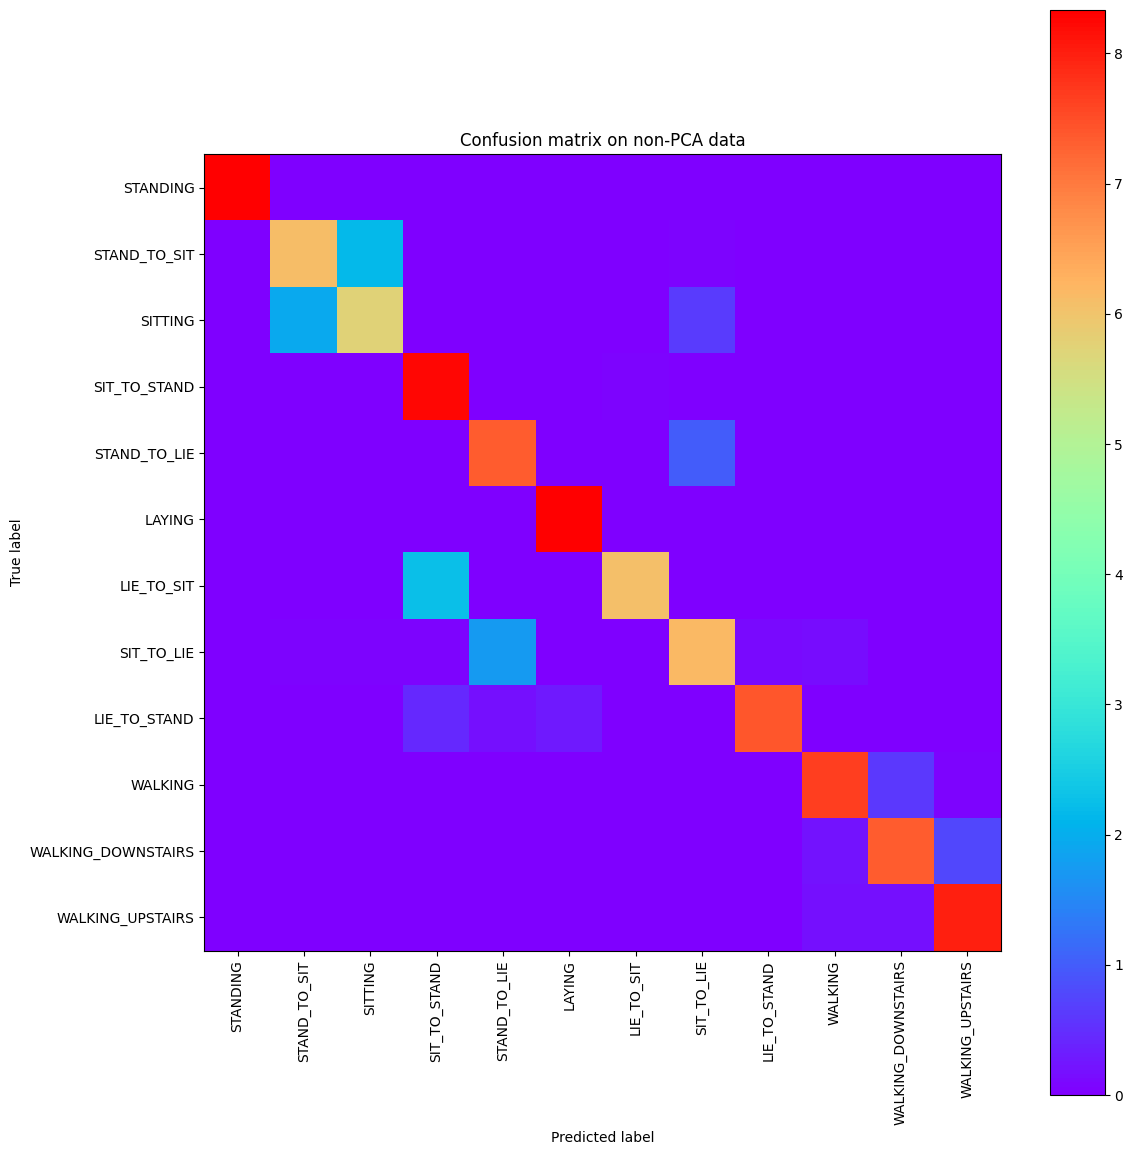

In [67]:
plt.figure(figsize=(12,12))
plt.imshow(normalised_conf_matrix, interpolation = 'nearest', cmap=plt.cm.rainbow)

plt.title("Confusion matrix on non-PCA data")
plt.colorbar()
plt.xticks(np.arange(12), activity_sm_label, rotation = 90)
plt.yticks(np.arange(12), activity_sm_label)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

There are instances where 'SIT_TO_LIE' is predicted as 'STAND_TO_LIE'.

In [68]:
pd.DataFrame([f1_sm_test] + [recall_sm_test] + [precision_sm_test], columns = activity_sm_label, index = ["F1 Score", "Recall Score", "Precision Score"])

,STANDING,STAND_TO_SIT,SITTING,SIT_TO_STAND,STAND_TO_LIE,LAYING,LIE_TO_SIT,SIT_TO_LIE,LIE_TO_STAND,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
F1 Score,0.838174,0.932075,0.854264,0.983201,0.762257,0.999100,0.743847,0.832625,0.704044,0.929220,0.892532,0.931004
Recall Score,0.726619,0.888489,0.991007,1.000000,0.741007,0.998201,0.733813,0.881295,0.688849,0.920863,0.881295,0.958633
Precision Score,0.990196,0.980159,0.750681,0.966957,0.784762,1.000000,0.754159,0.789050,0.719925,0.937729,0.904059,0.904924


Accuracy, F1 score, precision and recall generally decreased compared to under represented dataset, especially for transitional activity labels. We now move on to compare using PCA data.

In [69]:
# Do Dimentionality Reduction, Principal Component Analysis, with n_components = 120 (As found above), with random state = 1300
# Do it after splitting to prevent snooping

pca = PCA(n_components=120, random_state = 1300)  
X_sm_train = pca.fit_transform(train_sm_features)  
X_sm_val = pca.transform(val_sm_features)  
X_sm_test = pca.transform(test_sm_features)

In [70]:
# Running RandomForest with depth = 40, random state = 1300 for PCA validation set
clf = RandomForestClassifier(n_estimators = 200, max_depth = 40, max_features= 'log2', random_state = 1300)

start_time = timer()
fit = clf.fit(X_sm_train, train_sm_labels)
pred_sm_val2 = fit.predict(X_sm_val)


#Get evaluation metric
accuracy_sm_val2 = accuracy_score(val_sm_labels, pred_sm_val2)
elapsed_sm_val2 = timer() - start_time
f1_sm_val2 = f1_score(val_sm_labels, pred_sm_val2, average = None, labels = activity_sm_label)
avgf1_sm_val2 = f1_score(val_sm_labels, pred_sm_val2, average = "micro") # Same number for both macro and micro as number of samples in each class is the same
recall_sm_val2 = recall_score(val_sm_labels, pred_sm_val2, average = None, labels = activity_sm_label)
avgrecall_sm_val2 = recall_score(val_sm_labels, pred_sm_val2, average = "micro") # Same number for both macro and micro as number of samples in each class is the same
precision_sm_val2 = precision_score(val_sm_labels, pred_sm_val2, average = None, labels = activity_sm_label)
avgprec_sm_val2 = precision_score(val_sm_labels, pred_sm_val2, average = "micro") # Same number for both macro and micro as number of samples in each class is the same

In [71]:
print("Accuracy of SMOTE Validation Set: ", accuracy_sm_val2)
print("Average Precision Score of SMOTE Validation Set: ", avgprec_sm_val2)
print("Average Recall Score of SMOTE Validation Set: ", avgrecall_sm_val2)
print("Average F1 Score of SMOTE Validation Set: ", avgf1_sm_val2)
print("Run Time of SMOTE Validation Set:", elapsed_sm_val2)

Accuracy of SMOTE Validation Set:  0.9739461358313818
Average Precision Score of SMOTE Validation Set:  0.9739461358313818
Average Recall Score of SMOTE Validation Set:  0.9739461358313818
Average F1 Score of SMOTE Validation Set:  0.9739461358313818
Run Time of SMOTE Validation Set: 35.94365700000003


In [72]:
pd.DataFrame([f1_sm_val2] + [recall_sm_val2] + [precision_sm_val2], columns = activity_sm_label, index = ["F1 Score", "Recall Score", "Precision Score"])

,STANDING,STAND_TO_SIT,SITTING,SIT_TO_STAND,STAND_TO_LIE,LAYING,LIE_TO_SIT,SIT_TO_LIE,LIE_TO_STAND,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
F1 Score,0.899329,1.0,0.883303,1.0,1.0,0.989130,1.0,0.998347,1.0,0.976991,0.976407,0.964664
Recall Score,0.920962,1.0,0.848276,1.0,1.0,0.996350,1.0,1.000000,1.0,0.971831,0.974638,0.978495
Precision Score,0.878689,1.0,0.921348,1.0,1.0,0.982014,1.0,0.996700,1.0,0.982206,0.978182,0.951220


In [73]:
# Running RandomForest with depth = 40, random state = 1300 for for PCA test set
clf = RandomForestClassifier(n_estimators = 200, max_depth = 40, max_features= 'log2', random_state = 1300)

start_time = timer()
fit_test2 = clf.fit(X_sm_train, train_sm_labels)
pred_sm_test2 = fit_test2.predict(X_sm_test)

#Get evaluation metric
accuracy_sm_test2 = accuracy_score(test_sm_labels, pred_sm_test2)
elapsed_sm_test2 = timer() - start_time
f1_sm_test2 = f1_score(test_sm_labels, pred_sm_test2, average = None, labels = activity_sm_label)
avgf1_sm_test2 = f1_score(test_sm_labels, pred_sm_test2, average = "micro") # Same number for both macro and micro as number of samples in each class is the same
recall_sm_test2 = recall_score(test_sm_labels, pred_sm_test2, average = None, labels = activity_sm_label)
avgrecall_sm_test2 = recall_score(test_sm_labels, pred_sm_test2, average = "micro") # Same number for both macro and micro as number of samples in each class is the same
precision_sm_test2 = precision_score(test_sm_labels, pred_sm_test2, average = None, labels = activity_sm_label)
avgprec_sm_test2 = precision_score(test_sm_labels, pred_sm_test2, average = "micro") # Same number for both macro and micro as number of samples in each class is the same

In [74]:
print("Accuracy of SMOTE Test Set: ", accuracy_sm_test2)
print("Average Precision Score of SMOTE Test Set: ", avgprec_sm_test2)
print("Average Recall Score of SMOTE Test Set: ", avgrecall_sm_test2)
print("Average F1 Score of SMOTE Test Set: ", avgf1_sm_test2)
print("Run Time of SMOTE Test Set:", elapsed_sm_test2)

Accuracy of SMOTE Test Set:  0.8387290167865707
Average Precision Score of SMOTE Test Set:  0.8387290167865707
Average Recall Score of SMOTE Test Set:  0.8387290167865707
Average F1 Score of SMOTE Test Set:  0.8387290167865707
Run Time of SMOTE Test Set: 36.47258460000012


In [75]:
# confusion matrix
confusion_matrix_sm = confusion_matrix(test_sm_labels, pred_sm_test2)
print(confusion_matrix_sm)
normalised_confusion_matrix_sm = np.array(confusion_matrix_sm, dtype=np.float32)/np.sum(confusion_matrix_sm)*100 # normalize data
print(normalised_confusion_matrix_sm)

[[543   0   0  10   0   0   1   0   0   1   1   0]
 [  0 414 128   0   1   0   0   8   0   0   0   5]
 [  0 102 411   0   0   0   0  33   2   0   2   6]
 [  5   0   0 466   0   0  81   1   0   0   0   3]
 [  0   0   0   0 379   0   0 170   0   5   0   2]
 [  0   0   0   0   0 535   0   0   0   0   0  21]
 [  0   0   0  30   0   0 518   1   0   5   0   2]
 [  6   3   0   2 104   0   3 412   3   0   0  23]
 [  1   0   0  11  12   2   7  19 448  17   0  39]
 [  0   0   0   0   0   0   0   0   0 497  48  11]
 [  0   0   0   0   0   0   0   0   0  40 470  46]
 [  0   0   0   0   0   0   0   0   0  25  28 503]]
[[8.138489   0.         0.         0.1498801  0.         0.
  0.01498801 0.         0.         0.01498801 0.01498801 0.        ]
 [0.         6.205036   1.9184653  0.         0.01498801 0.
  0.         0.11990408 0.         0.         0.         0.07494005]
 [0.         1.528777   6.160072   0.         0.         0.
  0.         0.49460432 0.02997602 0.         0.02997602 0.08992806]


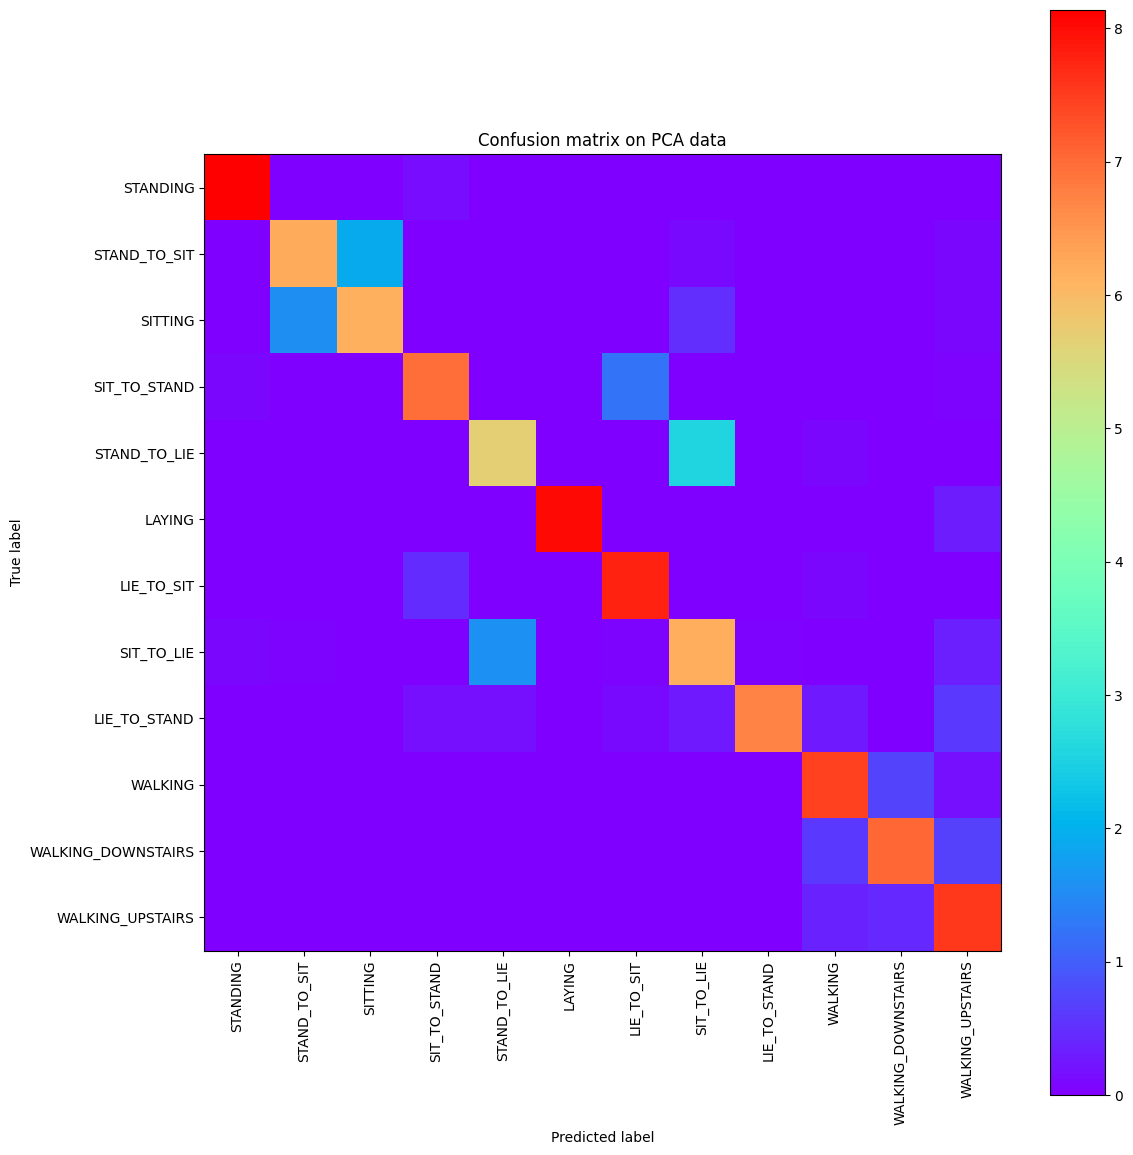

In [76]:
plt.figure(figsize=(12,12))
plt.imshow(normalised_confusion_matrix_sm, interpolation = 'nearest', cmap=plt.cm.rainbow)

plt.title("Confusion matrix on PCA data")
plt.colorbar()
plt.xticks(np.arange(12), activity_sm_label, rotation = 90)
plt.yticks(np.arange(12), activity_sm_label)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

When the true label is 'LIE_TO_SIT', there is a higher probability that it will be predicted as 'SIT_TO_STAND' instead.

In [77]:
pd.DataFrame([f1_sm_test2] + [recall_sm_test2] + [precision_sm_test2], columns = activity_sm_label, index = ["F1 Score", "Recall Score", "Precision Score"])

,STANDING,STAND_TO_SIT,SITTING,SIT_TO_STAND,STAND_TO_LIE,LAYING,LIE_TO_SIT,SIT_TO_LIE,LIE_TO_STAND,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
F1 Score,0.888508,0.888008,0.866977,0.978957,0.686667,0.977498,0.770233,0.720532,0.750685,0.867365,0.850679,0.826623
Recall Score,0.931655,0.805755,0.838129,0.962230,0.741007,0.976619,0.744604,0.681655,0.739209,0.893885,0.845324,0.904676
Precision Score,0.849180,0.988962,0.897881,0.996276,0.639752,0.978378,0.797688,0.764113,0.762523,0.842373,0.856102,0.760968


Comparing the 4 results

In [78]:
#Overall results

val_sm_res = [accuracy_sm_val, avgprec_sm_val, avgrecall_sm_val, avgf1_sm_val, elapsed_sm_val]
pca_val_sm_res = [accuracy_sm_val2, avgprec_sm_val2, avgrecall_sm_val2, avgf1_sm_val2, elapsed_sm_val2]
test_sm_res = [accuracy_sm_test, avgprec_sm_test, avgrecall_sm_test, avgf1_sm_test, elapsed_sm_test]
pca_test_sm_res = [accuracy_sm_test2, avgprec_sm_test2, avgrecall_sm_test2, avgf1_sm_test2, elapsed_sm_test2]

pd.DataFrame([val_sm_res] + [pca_val_sm_res] + [test_sm_res] + [pca_test_sm_res], columns = ["Accuracy", "Avg Precision", "Avg Recall", "Avg F1", "Run Time"], index = ["Validation", "PCA Validation", "Test", "PCA Test"])

,Accuracy,Avg Precision,Avg Recall,Avg F1,Run Time
Validation,0.993267,0.993267,0.993267,0.993267,51.293970
PCA Validation,0.973946,0.973946,0.973946,0.973946,35.943657
Test,0.867506,0.867506,0.867506,0.867506,50.750842
PCA Test,0.838729,0.838729,0.838729,0.838729,36.472585


Runtime seems to be better when using PCA data, however accuracy is compromised. 

In [79]:
pd.DataFrame([f1_sm_val] +[f1_sm_val2] + [recall_sm_val] + [recall_sm_val2] + [precision_sm_val] + [precision_sm_val2], columns = activity_sm_label, index = ["F1 Score", "PCA F1 Score", "Recall Score", "PCA Recall Score", "Precision Score", "PCA Precision Score"])

,STANDING,STAND_TO_SIT,SITTING,SIT_TO_STAND,STAND_TO_LIE,LAYING,LIE_TO_SIT,SIT_TO_LIE,LIE_TO_STAND,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
F1 Score,0.972789,0.996466,0.970228,1.0,0.996377,0.998172,1.0,1.000000,1.0,0.994709,0.994555,0.996429
PCA F1 Score,0.899329,1.000000,0.883303,1.0,1.000000,0.989130,1.0,0.998347,1.0,0.976991,0.976407,0.964664
Recall Score,0.982818,1.000000,0.955172,1.0,1.000000,0.996350,1.0,1.000000,1.0,0.992958,0.992754,1.000000
PCA Recall Score,0.920962,1.000000,0.848276,1.0,1.000000,0.996350,1.0,1.000000,1.0,0.971831,0.974638,0.978495
Precision Score,0.962963,0.992958,0.985765,1.0,0.992780,1.000000,1.0,1.000000,1.0,0.996466,0.996364,0.992883
PCA Precision Score,0.878689,1.000000,0.921348,1.0,1.000000,0.982014,1.0,0.996700,1.0,0.982206,0.978182,0.951220


For the validation set, the scores for stationary activity labels drop when using PCA data, except for precision score which increases when using PCA data.

In [80]:
pd.DataFrame([f1_sm_test] +[f1_sm_test2] + [recall_sm_test] + [recall_sm_test2] + [precision_sm_test] + [precision_sm_test2], columns = activity_sm_label, index = ["F1 Score", "PCA F1 Score", "Recall Score", "PCA Recall Score", "Precision Score", "PCA Precision Score"])

,STANDING,STAND_TO_SIT,SITTING,SIT_TO_STAND,STAND_TO_LIE,LAYING,LIE_TO_SIT,SIT_TO_LIE,LIE_TO_STAND,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
F1 Score,0.838174,0.932075,0.854264,0.983201,0.762257,0.999100,0.743847,0.832625,0.704044,0.929220,0.892532,0.931004
PCA F1 Score,0.888508,0.888008,0.866977,0.978957,0.686667,0.977498,0.770233,0.720532,0.750685,0.867365,0.850679,0.826623
Recall Score,0.726619,0.888489,0.991007,1.000000,0.741007,0.998201,0.733813,0.881295,0.688849,0.920863,0.881295,0.958633
PCA Recall Score,0.931655,0.805755,0.838129,0.962230,0.741007,0.976619,0.744604,0.681655,0.739209,0.893885,0.845324,0.904676
Precision Score,0.990196,0.980159,0.750681,0.966957,0.784762,1.000000,0.754159,0.789050,0.719925,0.937729,0.904059,0.904924
PCA Precision Score,0.849180,0.988962,0.897881,0.996276,0.639752,0.978378,0.797688,0.764113,0.762523,0.842373,0.856102,0.760968


For the test set, scores for PCA data drop drastically for almost all labels. Only precision score for PCA data for activity SIT_TO_STAND increased.